# **Práctico entregable**

Utilizar la base de jugadores “players_22.csv” disponible en la página de Kaggle https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset . Considerar que la base 2022 no tiene el mismo formato que la base vista en clase, a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde.

Con la nueva base, realizar un análisis análogo al que realizamos en el cursado de la materia con los datos FIFA2019. Realice comentarios en cada parte (verbose=True ;))

1- Análisis exploratorio de la base.

2- Evaluación visual  e intuitiva de a dos variables numéricas por vez.

3- Uso de dos técnicas de clustering: por ejemplo k-medias, DBSCAN, mezcla de Gaussianas y/o alguna jerárquica. Elección justificada de hiper-parámetros

4- Evaluación y Análisis de los clusters encontrados.

5- Pregunta: ¿Se realizó alguna normalización o escalado de la base? ¿Por qué ?

6- Uso de alguna transformación (proyección, Embedding) para visualizar los resultados y/o usarla como preprocesado para aplicar alguna técnica de clustering.


## Inicialización del entorno

In [ ]:
import itertools
from itertools import product
import io
import warnings

import numpy as np
import pandas as pd

# Visualización
%matplotlib inline
import plotly.express as px
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns

# Aprendizaje No Supervisado y Semi-Supervisado
from sklearn.cluster import KMeans, DBSCAN
# GMM o Mézcla de Gaussianas, usa Expectation Maximization
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    LabelBinarizer,
    OneHotEncoder,
)

# evaluación intrínseca con clases (métricas)
from sklearn.metrics import (
    silhouette_samples, # qué tan compactos son los clusters
    silhouette_score, # qué tan compactos son los clusterscompacto
    homogeneity_score,
    completeness_score,
    v_measure_score, # qué tan compactos son los clusterscompacto
    adjusted_rand_score, # qué tan compactos son los clusters?
    adjusted_mutual_info_score, # prob de que un elem vaya a estar en un cluster dada cierto valor de caracteristica
)

In [ ]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
warnings.filterwarnings("ignore")

In [ ]:
# gráficos con más resolución
sns.set_context(context='talk', font_scale=0.6)

In [ ]:
URL = 'https://drive.google.com/file/d/1hs_al_KEYlgB8b0YKl-LtW_4DLcRZAPQ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df = pd.read_csv(path)

## 1. EDA y Curación

### EyCD

In [ ]:
df.shape

(19239, 110)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(50)
memory usage: 16.1+ MB


In [ ]:
df.columns.tolist()

['sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agi

In [ ]:
# Análisis exploratorio de datos nulos
df.isnull().sum()

sofifa_id                          0
player_url                         0
short_name                         0
long_name                          0
player_positions                   0
overall                            0
potential                          0
value_eur                         74
wage_eur                          61
age                                0
dob                                0
height_cm                          0
weight_kg                          0
club_team_id                      61
club_name                         61
league_name                       61
league_level                      61
club_position                     61
club_jersey_number                61
club_loaned_from               18137
club_joined                     1163
club_contract_valid_until         61
nationality_id                     0
nationality_name                   0
nation_team_id                 18480
nation_position                18480
nation_jersey_number           18480
p

**Descripción de las variables de habilidades más específicas**

Fuente: https://www.fifplay.com/encyclopedia/


'ACrossing', = precisión de cruce

'AFinishing', = marcar un gol

'AHeadingAccuracy', = precisión al usar la cabeza para pasar, disparar o despejar el balón

'AShortPassing', = precisión en pases cortos

'AVolleys', = hacer un puntapié de la pelota hecho antes de que toque el suelo

'Dribbling', = capacidad de llevar el balón y pasar a un oponente mientras se tiene el control de la pelota

'Curve', = curvar la pelota
 
'FKAccuracy', 

'LongPassing', = pases largos

'BallControl', = control de la pelota

'Acceleration', = aceleración 

'SprintSpeed', = velocidad del sprint (correr) de un jugador

'Agility', = la velocidad y la gracia de un jugador en cuanto al control de la pelota

'Reactions', = velocidad de actuación de un jugador en respuesta a las situaciones que suceden a su alrededor.

'Balance', = distribución uniforme de permitir que un jugador permanezca erguido y estable

'ShotPower', = Potencia de tiros

'Jumping', = habilidad y calidad para saltar desde la superficie para cabezazos

'Stamina', = capacidad para soportar un esfuerzo físico o mental prolongado en un partido

'Strength', = cualidad o estado de ser físicamente fuerte de un jugador.

'LongShots', = precisión en tiros largos

'Aggression', = nivel de agresividad de un jugador cuando empuja/jala y taclea

'Interceptions', = capacidad de atrapar los pases del equipo contrario.

'Positioning', = capacidad de colocarse en la posición adecuada para recibir/atrapar el balón, marcar goles o realizar una jugada táctica.

'Vision', = conciencia mental sobre el posicionamiento de sus compañeros, para pasarles el balón.

'Penalties', = Precisión en los lanzamientos desde los tiros penales.

'Composure', = estado o sensación de estar tranquilo y controlar su frustración

'DMarking', = estrategia defensiva que tiene como objetivo evitar que un miembro del equipo contrario tome el control del balón

'DStandingTackle', = habilidad para performar tacleos estando de pie

'DSlidingTackle', = habilidad para performar un tacleo en el que usa su/s pierna/s para deslizarse hacia el cuerpo de su oponente para quitarle la pelota

'GKDiving', = capacidad de bucear como arquero

'GKHandling', = capacidad de retener la pelota como arquero

'GKKicking', = capacidad patear como arquero

'GKPositioning', = capacidad de colocarse en la posición adecuada para atrapar la pelota como arquero

'GKReflexes' = la capacidad y velocidad de reacción del arquero para atrapar la pelota

work_rate = ritmo de movimiento sin la pelota tanto para ataque como para defensa

**Realizamos el histograma de la variable "Overall" (Desempeño global)**

47


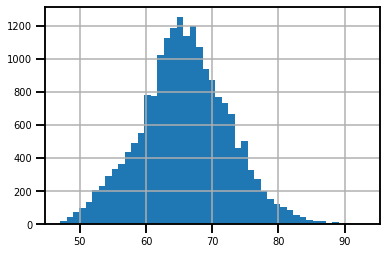

In [ ]:
nbins=1*(df.overall.max()-df.overall.min())+1
df['overall'].hist(bins = nbins)
print(nbins)

La variable **'Overall'** se calcula usando otras variables de desempeño del jugador (skills_ratings), utilizando redondeo

La variable 'Overall' es numérica discreta, (pero de "naturaleza" continua) así como las otras de desempeño según habilidad ('Crossing',
       'Finishing', 'HeadingAccuracy', etc.), tomando valores enteros entre 0 y 100, más allá del tipo de dato en estos casos.

In [ ]:
# Mapeamos los nombres de las columnas de habilidades para usar los nombres similares a los vistos en clase.
# Agregamos una A o D en algunas de acuerdo a pertencia a jugador de ataque o de defensa. 

new_col_names = {
    'overall': 'Overall',
    'attacking_crossing': 'ACrossing',
    'attacking_finishing': 'AFinishing',
    'attacking_heading_accuracy': 'AHeadingAccuracy',
    'attacking_short_passing': 'AShortPassing',
    'attacking_volleys': 'AVolleys',
    'skill_dribbling': 'Dribbling',
    'skill_curve': 'Curve',
    'skill_fk_accuracy': 'FKAccuracy',
    'skill_long_passing': 'LongPassing',
    'skill_ball_control': 'BallControl',
    'movement_acceleration': 'Acceleration',
    'movement_sprint_speed': 'SprintSpeed',
    'movement_agility': 'Agility',
    'movement_reactions': 'Reactions',
    'movement_balance': 'Balance',
    'power_shot_power': 'ShotPower',
    'power_jumping': 'Jumping',
    'power_stamina': 'Stamina',
    'power_strength': 'Strength',
    'power_long_shots': 'LongShots',
    'mentality_aggression': 'Aggression',
    'mentality_interceptions': 'Interceptions',
    'mentality_positioning': 'Positioning',
    'mentality_vision': 'Vision',
    'mentality_penalties': 'Penalties',
    'mentality_composure': 'Composure',
    'defending_marking_awareness': 'DMarking',
    'defending_standing_tackle': 'DStandingTackle',
    'defending_sliding_tackle': 'DSlidingTackle',
    'goalkeeping_diving': 'GKDiving',
    'goalkeeping_handling': 'GKHandling',
    'goalkeeping_kicking': 'GKKicking',
    'goalkeeping_positioning': 'GKPositioning',
    'goalkeeping_reflexes': 'GKReflexes'
} 
len(new_col_names)

35

In [ ]:
df = df.rename(columns=new_col_names)

**Selección de habilidades específicas a priori**

In [ ]:
# Retiramos jugadores con bajo Desempeño global ("Overall")
df = df[df['Overall'] > 70] # mejores jugadores

# Consideramos variables de desempeño por habilidad específicas (skills_ratings)
skills_ratings = ['ACrossing', 'AFinishing', 'AHeadingAccuracy', 'AShortPassing',
                  'AVolleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
                  'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                  'Composure', 'DMarking', 'DStandingTackle', 'DSlidingTackle',
                  'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 
                  'work_rate']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

35 variables numéricas: skills/habilidades


In [ ]:
df[skills_ratings].isnull().sum()

ACrossing           0
AFinishing          0
AHeadingAccuracy    0
AShortPassing       0
AVolleys            0
Dribbling           0
Curve               0
FKAccuracy          0
LongPassing         0
BallControl         0
Acceleration        0
SprintSpeed         0
Agility             0
Reactions           0
Balance             0
ShotPower           0
Jumping             0
Stamina             0
Strength            0
LongShots           0
Aggression          0
Interceptions       0
Positioning         0
Vision              0
Penalties           0
Composure           0
DMarking            0
DStandingTackle     0
DSlidingTackle      0
GKDiving            0
GKHandling          0
GKKicking           0
GKPositioning       0
GKReflexes          0
work_rate           0
dtype: int64

In [ ]:
# Entrada, matriz de datos X
df[skills_ratings]

ACrossing  AFinishing  AHeadingAccuracy  AShortPassing  AVolleys  \
0            85          95                70             91        88   
1            71          95                90             85        89   
2            87          95                90             80        86   
3            85          83                63             86        86   
4            94          82                55             94        82   
...         ...         ...               ...            ...       ...   
4588         46          55                49             75        37   
4589         66          60                62             73        58   
4590         70          61                49             71        29   
4591         64          74                72             63        58   
4592         57          61                54             70        61   

      Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0            96     93          94           91           96            91   
1            85     79          85           70           88            77   
2            88     81          84           77           88            85   
3            95     88          87           81           95            93   
4            88     85          83           93           91            76   
...         ...    ...         ...          ...          ...           ...   
4588         65     56          65           73           70            63   
4589         73     73          63           70           70            69   
4590         71     74          35           69           72            80   
4591         66     56          49           57           65            79   
4592         71     60          49           74           78            59   

      SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  \
0              80       91         94       95         86       68       72   
1              79       77         93       82         90       85       76   
2              88       86         94       74         94       95       77   
3              89       96         89       84         80       64       81   
4              76       79         91       78         91       63       89   
...           ...      ...        ...      ...        ...      ...      ...   
4588           59       61         68       57         52       61       69   
4589           66       74         69       65         73       67       81   
4590           82       67         58       65         45       69       73   
4591           74       55         70       75         74       68       65   
4592           62       53         71       55         62       61       78   

      Strength  LongShots  Aggression  Interceptions  Positioning  Vision  \
0           69         94          44             40           93      95   
1           86         87          81             49           95      81   
2           77         93          63             29           95      76   
3           53         81          63             37           86      90   
4           74         91          76             66           88      94   
...        ...        ...         ...            ...          ...     ...   
4588        53         64          58             69           67      75   
4589        77         65          83             70           68      70   
4590        70         40          50             64           65      59   
4591        74         63          70             30           73      59   
4592        72         66          72             66           68      71   

      Penalties  Composure  DMarking  DStandingTackle  DSlidingTackle  \
0            75         96        20               35              24   
1            90         88        35               42              19   
2            88         95        24               32              24   
3            9

#### **Creación de variable Position**

Creemos que la posición del jugador puede tener que ver con la formación de clusters.

**Creamos una nueva variable categórica recodificando la posición para simplificar el análisis de los resultados de clustering**

In [ ]:
df.club_position.unique()

array(['RW', 'ST', 'LW', 'RCM', 'GK', 'CF', 'CDM', 'LCB', 'RDM', 'RS',
       'LCM', 'SUB', 'CAM', 'RCB', 'LDM', 'LB', 'RB', 'LM', 'RM', 'LS',
       'CB', 'RES', nan, 'RWB', 'RF', 'CM', 'LWB', 'LAM', 'LF', 'RAM'],
      dtype=object)

In [ ]:
forwards = ['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW']
midfielders = ['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
defenders = ['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers = ['GK']

def pos2(position):
    if position in forwards:
        return 'Forward'
    
    elif position in midfielders:
        return 'Midfielder'
    
    elif position in defenders:
        return 'Defender'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        # RES (reserva), SUB (suplente) or NaN
        return np.NaN

In [ ]:
df["Position"] = df["club_position"].apply(lambda x: pos2(x))

df["Position"].value_counts()

Defender      915
Forward       827
Midfielder    759
GK            286
Name: Position, dtype: int64

#### **Imputación de la variable Position**

In [ ]:
df.player_positions.unique()

array(['RW, ST, CF', 'ST', 'ST, LW', 'LW, CAM', 'CM, CAM', 'GK',
       'CDM, CM', 'CF, ST', 'LM, CF, LW', 'CDM', 'CB', 'LW', 'RW',
       'CDM, RB', 'CM', 'LW, RW', 'CAM', 'RW, LW', 'CAM, RM, RW',
       'CM, LM', 'CB, CDM', 'CM, CDM', 'CF, CAM', 'LB', 'CM, CDM, CB',
       'RB', 'RM, CF, LM', 'LB, LM', 'LW, CF', 'RW, RM', 'ST, RM, RW',
       'CDM, CB', 'RB, LB', 'LM, RM, LW', 'CAM, CM, RW', 'CM, RM, ST',
       'CAM, CF, CM', 'CAM, CM', 'CAM, CF', 'ST, LW, LM', 'ST, LW, RW',
       'CF', 'CF, LW, CAM', 'RM, LM, RW', 'CM, CDM, CAM', 'LM, ST',
       'RB, RWB', 'RB, RM', 'CF, ST, CAM', 'RB, RWB, RM', 'ST, RW',
       'CB, LB', 'CAM, CM, CF', 'LW, CF, CAM', 'LW, LM, CAM', 'LM, LWB',
       'RW, CAM', 'CAM, RM, ST', 'RM, LM', 'CAM, LW, CM', 'RW, LW, CAM',
       'CB, RWB', 'CM, CAM, CDM', 'CAM, RM, LM', 'CM, CDM, LM',
       'CF, RM, RW', 'ST, CF', 'LWB, LB, LM', 'LB, LWB, LM', 'LM, CM, RM',
       'ST, RM', 'ST, CAM', 'LWB, LM', 'LB, CB', 'CAM, RM', 'RW, LW, RM',
       'RM, RW', 'CAM,

In [ ]:
rows_sub = df.loc[df['club_position'] == 'SUB']
len(rows_sub)

1583

In [ ]:
rows_res = df.loc[df['club_position'] == 'RES']
len(rows_res)

198

In [ ]:
df.loc[df['club_position'] == 'SUB'][['player_positions','nation_position']].head(5)

player_positions nation_position
26               GK             NaN
27           LW, RW              LW
33           RW, LW              LW
47               CB             LCB
64       LM, RM, LW             SUB

In [ ]:
df.loc[df['club_position'] == 'RES'][['player_positions']].head(5)

player_positions
146               CB
165      LWB, LB, LM
213          CM, CAM
351      RWB, RB, RM
409               GK

> Imputaremos con las posiciones del jugador, debido a que la posición del club nacional tiene muchos nulos.

In [ ]:
def split_pos(pos_str):
  if not isinstance(pos_str, str):
    return []

  return [ lang.strip().replace(',', '')
          for lang in pos_str.split() ]

In [ ]:
def player_pos2(data):
    dict_to_impute = {}

    for i in range(data.shape[0]):
      player_pos = split_pos(data.iloc[i].player_positions)
      for pos in player_pos:
        if pos in forwards:
            dict_to_impute.update({ data.index[i]: 'Forward' })
            break
        
        elif pos in midfielders:
            dict_to_impute.update({ data.index[i]: 'Midfielder' })
            break
        
        elif pos in defenders:
            dict_to_impute.update({ data.index[i]: 'Defender' })
            break
        
        elif pos in goalkeepers:
            dict_to_impute.update({ data.index[i]: 'GK' })
            break
        
        else:
            # is NaN
            dict_to_impute.update({ data.index[i]: np.NaN })
            break
        
    return dict_to_impute

In [ ]:
dict_to_impute_sub = player_pos2(rows_sub)

In [ ]:
dict_to_impute_res = player_pos2(rows_res)

In [ ]:
df['Position'].isna().sum()

1806

In [ ]:
df["Position"] = df["Position"].fillna(dict_to_impute_sub)

In [ ]:
df['Position'].isna().sum()

223

In [ ]:
df["Position"] = df["Position"].fillna(dict_to_impute_res)

In [ ]:
df['Position'].isna().sum()

25

In [ ]:
# eliminamos las posiciones más específicas
position_split_list = [ 'ls', 'st', 'rs', 'lw',
       'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm',
       'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb',
       'gk' ]

In [ ]:
df[:3]

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1     188545  https://sofifa.com/player/188545/robert-lewand...   
2      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   

          short_name                            long_name player_positions  \
0           L. Messi       Lionel Andrés Messi Cuccittini       RW, ST, CF   
1     R. Lewandowski                   Robert Lewandowski               ST   
2  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro           ST, LW   

   Overall  potential    value_eur  wage_eur  age         dob  height_cm  \
0       93         93   78000000.0  320000.0   34  1987-06-24        170   
1       92         92  119500000.0  270000.0   32  1988-08-21        185   
2       91         91   45000000.0  270000.0   36  1985-02-05        187   

   weight_kg  club_team_id            club_name             league_name  \
0         72          73.0  Paris Saint-Germain          French Ligue 1   
1         81          21.0    FC Bayern München    German 1. Bundesliga   
2         83          11.0    Manchester United  English Premier League   

   league_level club_position  club_jersey_number club_loaned_from  \
0           1.0            RW                30.0              NaN   
1           1.0            ST                 9.0              NaN   
2           1.0            ST                 7.0              NaN   

  club_joined  club_contract_valid_until  nationality_id nationality_name  \
0  2021-08-10                     2023.0              52        Argentina   
1  2014-07-01                     2023.0              37           Poland   
2  2021-08-27                     2023.0              38         Portugal   

   nation_team_id nation_position  nation_jersey_number preferred_foot  \
0          1369.0              RW                  10.0           Left   
1          1353.0              RS                   9.0          Right   
2          1354.0              ST                   7.0          Right   

   weak_foot  skill_moves  international_reputation    work_rate body_type  \
0          4            4                         5   Medium/Low    Unique   
1          4            4                         5  High/Medium    Unique   
2          4            5                         5     High/Low    Unique   

  real_face  release_clause_eur  \
0       Yes         144300000.0   
1       Yes         197200000.0   
2       Yes          83300000.0   

                                         player_tags  \
0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1  #Aerial Threat, #Distance Shooter, #Clinical F...   
2  #Aerial Threat, #Dribbler, #Distance Shooter, ...   

                                       player_traits  pace  shooting  passing  \
0  Finesse Shot, Long Shot Taker (AI), Playmaker ...  85.0      92.0     91.0   
1  Solid Player, Finesse Shot, Outside Foot Shot,...  78.0      92.0     79.0   
2  Power Free-Kick, Flair, Long Shot Taker (AI), ...  87.0      94.0     80.0   

   dribbling  defending  physic  ACrossing  AFinishing  AHeadingAccuracy  \
0       95.0       34.0    65.0         85          95                70   
1       86.0       44.0    82.0         71          95                90   
2       88.0       34.0    75.0         87          95                90   

   AShortPassing  AVolleys  Dribbling  Curve  ...  Strength  LongShots  \
0             91        88         96     93  ...        69         94   
1             85        89         85     79  ...        86         87   
2             80        86         88     81  ...        77         93   

   Aggression  Interceptions  Positioning  Vision  Penalties  Composure  \
0          44             40           93      95         75         96   
1          81             49           95      81         90         88   
2          63             29           95      76         88         95   

   DMarking  DStandin

In [ ]:
df = df.drop(position_split_list, axis=1)
df.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'Overall', 'potential', 'value_eur', 'wage_eur',
       'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id', 'club_name',
       'league_name', 'league_level', 'club_position', 'club_jersey_number',
       'club_loaned_from', 'club_joined', 'club_contract_valid_until',
       'nationality_id', 'nationality_name', 'nation_team_id',
       'nation_position', 'nation_jersey_number', 'preferred_foot',
       'weak_foot', 'skill_moves', 'international_reputation', 'work_rate',
       'body_type', 'real_face', 'release_clause_eur', 'player_tags',
       'player_traits', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'ACrossing', 'AFinishing', 'AHeadingAccuracy',
       'AShortPassing', 'AVolleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 

**Análisis de variables no-habilidades y de work_rate**

In [ ]:
df.league_level.value_counts()

1.0    4112
2.0     452
3.0       4
Name: league_level, dtype: int64

In [ ]:
df.body_type.value_counts()

Normal (170-185)    1576
Normal (185+)       1079
Lean (170-185)       814
Lean (185+)          426
Stocky (170-185)     182
Normal (170-)        154
Unique               134
Stocky (185+)        114
Lean (170-)           78
Stocky (170-)         36
Name: body_type, dtype: int64

In [ ]:
df.body_type.value_counts().sum()

4593

In [ ]:
df.player_tags.value_counts().sum()

820

In [ ]:
df.international_reputation.unique()

array([5, 4, 3, 2, 1])

In [ ]:
df.international_reputation.value_counts()

1    3299
2     947
3     282
4      57
5       8
Name: international_reputation, dtype: int64

In [ ]:
not_skills = [ 
    'short_name', # nombre
    'potential', # potencial
    'value_eur', # valorización en euros 
    'wage_eur', # salario en euros
    'age', # edad
    'height_cm', # altura
    'weight_kg', # peso
    'club_name', # club
    'league_name', # liga
    'club_joined', # fecha de ingreso al club
    'nationality_name', # nacionalidad
    'preferred_foot', # pie hábil
    'international_reputation', # reputación internacional
    'Position' # rol en el campo
]
len(not_skills)

14

In [ ]:
df.work_rate.unique()

array(['Medium/Low', 'High/Medium', 'High/Low', 'High/High',
       'Medium/Medium', 'Medium/High', 'Low/High', 'Low/Medium',
       'Low/Low'], dtype=object)

In [ ]:
df.work_rate.value_counts()

Medium/Medium    1735
High/Medium      1138
Medium/High       572
High/High         483
High/Low          243
Medium/Low        200
Low/High          127
Low/Medium         90
Low/Low             5
Name: work_rate, dtype: int64

**Creación del dataframe considerando las columnas de habilidades y no habilidades**

In [ ]:
df_to_work = df[skills_ratings+not_skills+['Overall']]

In [ ]:
df_to_work.isna().sum()

ACrossing                     0
AFinishing                    0
AHeadingAccuracy              0
AShortPassing                 0
AVolleys                      0
Dribbling                     0
Curve                         0
FKAccuracy                    0
LongPassing                   0
BallControl                   0
Acceleration                  0
SprintSpeed                   0
Agility                       0
Reactions                     0
Balance                       0
ShotPower                     0
Jumping                       0
Stamina                       0
Strength                      0
LongShots                     0
Aggression                    0
Interceptions                 0
Positioning                   0
Vision                        0
Penalties                     0
Composure                     0
DMarking                      0
DStandingTackle               0
DSlidingTackle                0
GKDiving                      0
GKHandling                    0
GKKickin

In [ ]:
df_to_work.describe()

ACrossing   AFinishing  AHeadingAccuracy  AShortPassing     AVolleys  \
count  4593.000000  4593.000000       4593.000000    4593.000000  4593.000000   
mean     58.539081    54.379708         58.895058      68.204659    51.389506   
std      19.092449    20.736965         18.441365      13.691455    19.404293   
min       6.000000     3.000000          7.000000      11.000000     4.000000   
25%      50.000000    40.000000         51.000000      67.000000    37.000000   
50%      65.000000    61.000000         63.000000      72.000000    56.000000   
75%      72.000000    71.000000         72.000000      75.000000    67.000000   
max      94.000000    95.000000         93.000000      94.000000    90.000000   

         Dribbling        Curve   FKAccuracy  LongPassing  BallControl  \
count  4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean     64.754844    57.428478    50.694100    62.662530    67.868278   
std      18.790148    19.621255    19.266658    14.246775    16.244533   
min       7.000000     6.000000     4.000000     9.000000     9.000000   
25%      62.000000    46.000000    37.000000    58.000000    67.000000   
50%      71.000000    63.000000    53.000000    66.000000    73.000000   
75%      76.000000    72.000000    67.000000    72.000000    76.000000   
max      96.000000    94.000000    94.000000    93.000000    96.000000   

       Acceleration  SprintSpeed      Agility    Reactions      Balance  \
count   4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean      68.033312    68.233181    68.194644    71.880688    66.395820   
std       14.600173    14.350843    14.385996     5.602323    14.551366   
min       15.000000    16.000000    19.000000    38.000000    20.000000   
25%       60.000000    61.000000    61.000000    68.000000    58.000000   
50%       70.000000    71.000000    71.000000    72.000000    69.000000   
75%       78.000000    78.000000    78.000000    75.000000    77.000000   
max       97.000000    97.000000    96.000000    94.000000    96.000000   

         ShotPower      Jumping      Stamina     Strength    LongShots  \
count  4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean     67.581755    68.996299    69.880253    70.008709    56.822121   
std      11.734575    12.139747    15.174882    11.516668    20.163787   
min      21.000000    29.000000    13.000000    28.000000     4.000000   
25%      59.000000    62.000000    66.000000    64.000000    46.000000   
50%      70.000000    71.000000    73.000000    71.000000    64.000000   
75%      76.000000    77.000000    80.000000    78.000000    71.000000   
max      95.000000    95.000000    97.000000    95.000000    94.000000   

        Aggression  Interceptions  Positioning       Vision    Penalties  \
count  4593.000000    4593.000000  4593.000000  4593.000000  4593.000000   
mean     64.157413      54.615720    59.258437    63.539952    54.755062   
std      17.047454      21.840682    20.726463    13.164588    16.713052   
min      11.000000       6.000000     3.000000    10.000000     8.000000   
25%      55.000000      34.000000    51.000000    57.000000    44.000000   
50%      69.000000      65.000000    67.000000    67.000000    57.000000   
75%      76.000000      73.000000    74.000000    73.000000    67.000000   
max      95.000000      91.000000    96.000000    95.000000    93.000000   

         Composure     DMarking  DStandingTackle  DSlidingTackle     GKDiving  \
count  4593.000000  4593.000000      4593.000000     4593.000000  4593.000000   
mean     69.177008    54.231004        54.760941       51.781842    16.772480   
std       9.318305    21.376009        22.960927       23.029671    19.415508   
min      18.000000     5.000000         7.000000        7.000000     2.000000   
25%      65.000000    35.000000        33.000000       29.000000     8.000000   
50%      70.000000    64.000000        67.000000       62.000000    11.000000   
75%      75.00000

#### **Curación de work_rate**

In [ ]:
# Hacemos codificación de esta habilidad ya que es categorica y con cierto orden
enc = LabelEncoder() 
df_to_work['work_rate'] = enc.fit_transform(df_to_work['work_rate'])
df_to_work['work_rate'].unique()

array([7, 2, 1, 0, 8, 6, 3, 5, 4])

#### **Curación de variables no-habilidades**

Exploramos los registros faltantes de las variables que no refieren a habilidad:

`value_eur`, `wage_eur`, `club_name`, `league_name`, `club_joined`

In [ ]:
rows_not_skills_nan = df_to_work[
    (df_to_work.value_eur.isna()) |
    (df_to_work.wage_eur.isna()) |
    (df_to_work.club_name.isna()) |
    (df_to_work.league_name.isna()) |
    (df_to_work.club_joined.isna())
]
len(rows_not_skills_nan)

318

In [ ]:
df_to_work[not_skills].describe()

potential     value_eur       wage_eur          age    height_cm  \
count  4593.000000  4.565000e+03    4568.000000  4593.000000  4593.000000   
mean     76.964293  9.083767e+06   27830.056918    27.549532   181.591552   
std       4.557132  1.381575e+07   32960.186911     4.107786     6.917536   
min      71.000000  2.100000e+05     500.000000    17.000000   158.000000   
25%      73.000000  2.400000e+06   10000.000000    25.000000   177.000000   
50%      76.000000  4.200000e+06   18000.000000    27.000000   182.000000   
75%      80.000000  9.500000e+06   33000.000000    30.000000   187.000000   
max      95.000000  1.940000e+08  350000.000000    43.000000   201.000000   

         weight_kg  international_reputation  
count  4593.000000               4593.000000  
mean     76.090790                  1.373177  
std       7.155581                  0.672438  
min      55.000000                  1.000000  
25%      71.000000                  1.000000  
50%      76.000000                  1.000000  
75%      81.000000                  2.000000  
max     103.000000                  5.000000

In [ ]:
df_to_work[not_skills].dtypes

short_name                   object
potential                     int64
value_eur                   float64
wage_eur                    float64
age                           int64
height_cm                     int64
weight_kg                     int64
club_name                    object
league_name                  object
club_joined                  object
nationality_name             object
preferred_foot               object
international_reputation      int64
Position                     object
dtype: object

Vemos que `value_eur` y `wage_eur` son numéricas, así que usaremos la media para imputar en estas variables.

A su vez `club_name`, `league_name`, `club_joined` son categóricas, así que usaremos la moda para imputarlas.

In [ ]:
df_to_work.columns

Index(['ACrossing', 'AFinishing', 'AHeadingAccuracy', 'AShortPassing',
       'AVolleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'DMarking', 'DStandingTackle', 'DSlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'work_rate', 'short_name', 'potential', 'value_eur', 'wage_eur', 'age',
       'height_cm', 'weight_kg', 'club_name', 'league_name', 'club_joined',
       'nationality_name', 'preferred_foot', 'international_reputation',
       'Position', 'Overall'],
      dtype='object')

In [ ]:
df_to_work.iloc[:,37:39]

value_eur  wage_eur
0      78000000.0  320000.0
1     119500000.0  270000.0
2      45000000.0  270000.0
3     129000000.0  270000.0
4     125500000.0  350000.0
...           ...       ...
4588    4500000.0   51000.0
4589    2800000.0   24000.0
4590    1700000.0     600.0
4591    4200000.0   15000.0
4592    3900000.0     550.0

[4593 rows x 2 columns]

In [ ]:
df_to_work.iloc[:,42:45]

club_name                    league_name club_joined
0     Paris Saint-Germain                 French Ligue 1  2021-08-10
1       FC Bayern München           German 1. Bundesliga  2014-07-01
2       Manchester United         English Premier League  2021-08-27
3     Paris Saint-Germain                 French Ligue 1  2017-08-03
4         Manchester City         English Premier League  2015-08-30
...                   ...                            ...         ...
4588       Real Madrid CF         Spain Primera Division  2020-07-01
4589        Fenerbahçe SK              Turkish Süper Lig  2021-09-06
4590     Panathinaikos FC             Greek Super League  2021-06-22
4591             Cádiz CF         Spain Primera Division  2021-07-10
4592      Ferencvárosi TC  Hungarian Nemzeti Bajnokság I  2021-07-16

[4593 rows x 3 columns]

In [ ]:
df_cured = df_to_work.copy()

In [ ]:
mean_imputer = SimpleImputer(strategy='mean')

df_cured.iloc[:,37:39] = mean_imputer.fit_transform(df_cured.iloc[:,37:39])

In [ ]:
df_cured.isna().sum()

ACrossing                     0
AFinishing                    0
AHeadingAccuracy              0
AShortPassing                 0
AVolleys                      0
Dribbling                     0
Curve                         0
FKAccuracy                    0
LongPassing                   0
BallControl                   0
Acceleration                  0
SprintSpeed                   0
Agility                       0
Reactions                     0
Balance                       0
ShotPower                     0
Jumping                       0
Stamina                       0
Strength                      0
LongShots                     0
Aggression                    0
Interceptions                 0
Positioning                   0
Vision                        0
Penalties                     0
Composure                     0
DMarking                      0
DStandingTackle               0
DSlidingTackle                0
GKDiving                      0
GKHandling                    0
GKKickin

In [ ]:
mode_imputer = SimpleImputer(strategy='most_frequent')
df_cured.iloc[:,42:45] = mode_imputer.fit_transform(df_cured.iloc[:,42:45])

In [ ]:
df_cured.isna().sum()

ACrossing                    0
AFinishing                   0
AHeadingAccuracy             0
AShortPassing                0
AVolleys                     0
Dribbling                    0
Curve                        0
FKAccuracy                   0
LongPassing                  0
BallControl                  0
Acceleration                 0
SprintSpeed                  0
Agility                      0
Reactions                    0
Balance                      0
ShotPower                    0
Jumping                      0
Stamina                      0
Strength                     0
LongShots                    0
Aggression                   0
Interceptions                0
Positioning                  0
Vision                       0
Penalties                    0
Composure                    0
DMarking                     0
DStandingTackle              0
DSlidingTackle               0
GKDiving                     0
GKHandling                   0
GKKicking                    0
GKPositi

In [ ]:
df_cured.describe()

ACrossing   AFinishing  AHeadingAccuracy  AShortPassing     AVolleys  \
count  4593.000000  4593.000000       4593.000000    4593.000000  4593.000000   
mean     58.539081    54.379708         58.895058      68.204659    51.389506   
std      19.092449    20.736965         18.441365      13.691455    19.404293   
min       6.000000     3.000000          7.000000      11.000000     4.000000   
25%      50.000000    40.000000         51.000000      67.000000    37.000000   
50%      65.000000    61.000000         63.000000      72.000000    56.000000   
75%      72.000000    71.000000         72.000000      75.000000    67.000000   
max      94.000000    95.000000         93.000000      94.000000    90.000000   

         Dribbling        Curve   FKAccuracy  LongPassing  BallControl  \
count  4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean     64.754844    57.428478    50.694100    62.662530    67.868278   
std      18.790148    19.621255    19.266658    14.246775    16.244533   
min       7.000000     6.000000     4.000000     9.000000     9.000000   
25%      62.000000    46.000000    37.000000    58.000000    67.000000   
50%      71.000000    63.000000    53.000000    66.000000    73.000000   
75%      76.000000    72.000000    67.000000    72.000000    76.000000   
max      96.000000    94.000000    94.000000    93.000000    96.000000   

       Acceleration  SprintSpeed      Agility    Reactions      Balance  \
count   4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean      68.033312    68.233181    68.194644    71.880688    66.395820   
std       14.600173    14.350843    14.385996     5.602323    14.551366   
min       15.000000    16.000000    19.000000    38.000000    20.000000   
25%       60.000000    61.000000    61.000000    68.000000    58.000000   
50%       70.000000    71.000000    71.000000    72.000000    69.000000   
75%       78.000000    78.000000    78.000000    75.000000    77.000000   
max       97.000000    97.000000    96.000000    94.000000    96.000000   

         ShotPower      Jumping      Stamina     Strength    LongShots  \
count  4593.000000  4593.000000  4593.000000  4593.000000  4593.000000   
mean     67.581755    68.996299    69.880253    70.008709    56.822121   
std      11.734575    12.139747    15.174882    11.516668    20.163787   
min      21.000000    29.000000    13.000000    28.000000     4.000000   
25%      59.000000    62.000000    66.000000    64.000000    46.000000   
50%      70.000000    71.000000    73.000000    71.000000    64.000000   
75%      76.000000    77.000000    80.000000    78.000000    71.000000   
max      95.000000    95.000000    97.000000    95.000000    94.000000   

        Aggression  Interceptions  Positioning       Vision    Penalties  \
count  4593.000000    4593.000000  4593.000000  4593.000000  4593.000000   
mean     64.157413      54.615720    59.258437    63.539952    54.755062   
std      17.047454      21.840682    20.726463    13.164588    16.713052   
min      11.000000       6.000000     3.000000    10.000000     8.000000   
25%      55.000000      34.000000    51.000000    57.000000    44.000000   
50%      69.000000      65.000000    67.000000    67.000000    57.000000   
75%      76.000000      73.000000    74.000000    73.000000    67.000000   
max      95.000000      91.000000    96.000000    95.000000    93.000000   

         Composure     DMarking  DStandingTackle  DSlidingTackle     GKDiving  \
count  4593.000000  4593.000000      4593.000000     4593.000000  4593.000000   
mean     69.177008    54.231004        54.760941       51.781842    16.772480   
std       9.318305    21.376009        22.960927       23.029671    19.415508   
min      18.000000     5.000000         7.000000        7.000000     2.000000   
25%      65.000000    35.000000        33.000000       29.000000     8.000000   
50%      70.000000    64.000000        67.000000       62.000000    11.000000   
75%      75.00000

### Análisis y Selección de variables según correlación

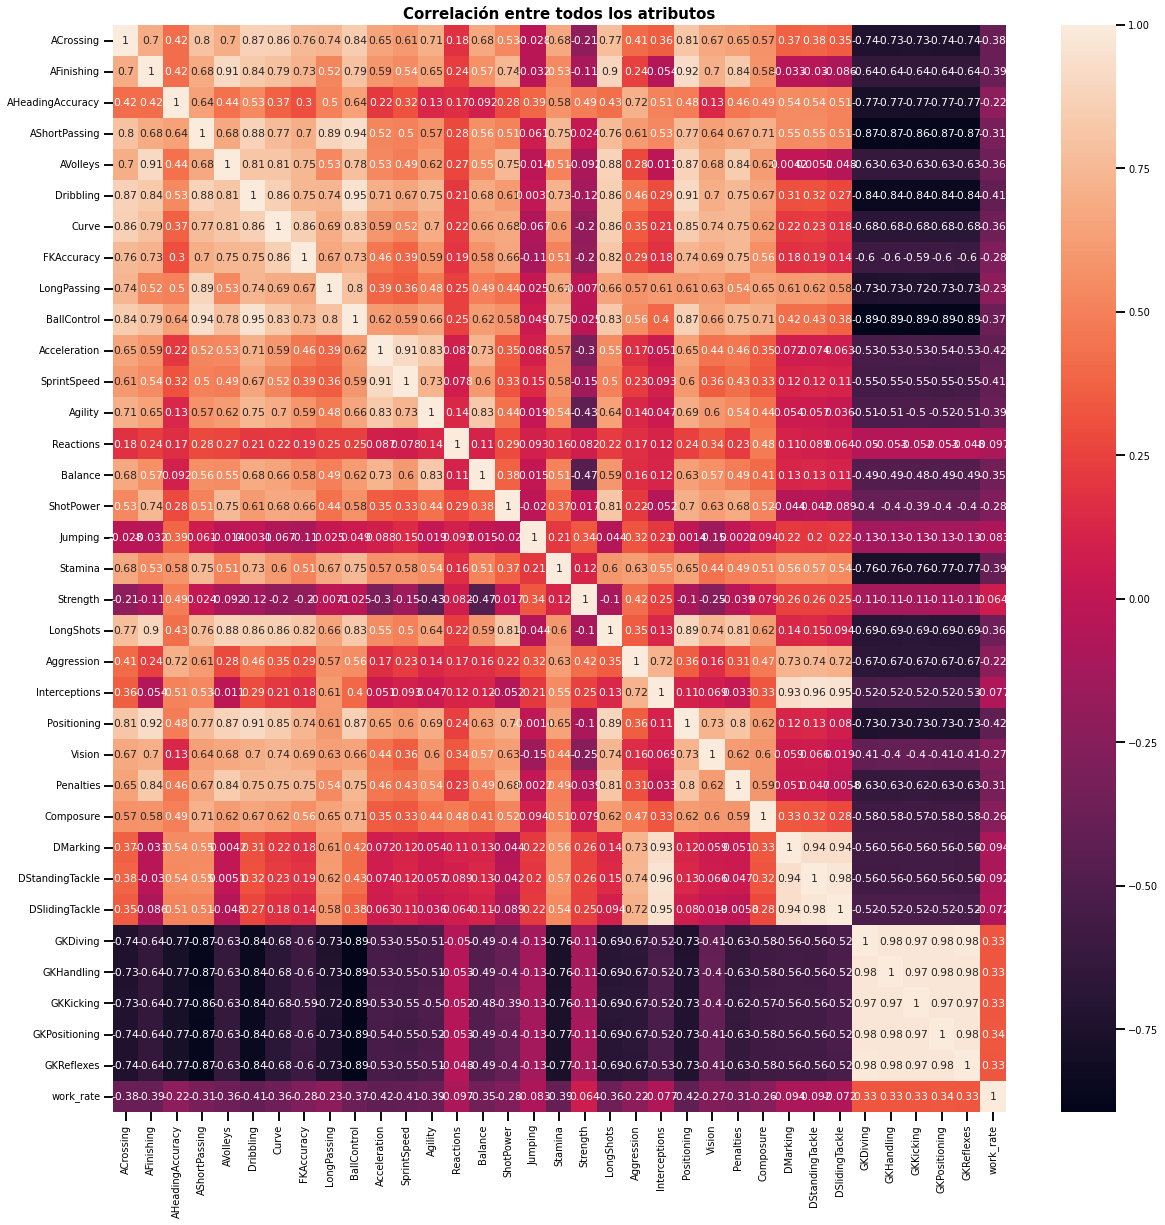

In [ ]:
# Graficamos un mapa de calor
fig = plt.figure(figsize=(20,20))
plt.title('Correlación entre todos los atributos', 
            loc='center', fontsize=15, fontweight='bold'
)
corr_matrix = df_to_work[skills_ratings].corr()
sns.heatmap(corr_matrix, fmt='.2g', annot=True)

In [ ]:
# crear un dataframe para distinguir cuáles columnas están más correlacionadas y cuáles no
dic = {'Name': None,
        'Index_names':[],
        'Values':[],
        'Max_index': None,
        'Max_value': None,
       }

df_pos = pd.DataFrame(dic)
df_pos

Empty DataFrame
Columns: [Name, Index_names, Values, Max_index, Max_value]
Index: []

In [ ]:
for col in corr_matrix.columns:
    filtered_rows = []
    # escoger los registros que tengan valores con la columna de acuerdo al criterio 
    # seleccionado (mayores a 0.80, excluyendo la misma columna que tiene valor 1)
    filtered_rows = corr_matrix.loc[(corr_matrix[col] >= 0.80) & (corr_matrix[col] < 1)]
    if not filtered_rows.empty:
      # crear un arreglo de los índices 
      indices = filtered_rows[col].index.to_numpy()
      # crear un arreglo de los valores
      values = filtered_rows[col].values
      # obtener el nombre de la columna que tiene el mayor valor
      max_idx = filtered_rows[col].idxmax()
      # obtener el mayor valor
      max_value = filtered_rows[col].max()
      # ingresar en el dataframe creado un registro con estos valores
      df_pos.loc[len(df_pos.index)] = [col, indices, values, max_idx, max_value] 
    else:
      df_pos.loc[len(df_pos.index)] = [col, [], [], '-', '-'] 

In [ ]:
pd.options.display.max_colwidth = 105

In [ ]:
df_pos

Name  \
0          ACrossing   
1         AFinishing   
2   AHeadingAccuracy   
3      AShortPassing   
4           AVolleys   
5          Dribbling   
6              Curve   
7         FKAccuracy   
8        LongPassing   
9        BallControl   
10      Acceleration   
11       SprintSpeed   
12           Agility   
13         Reactions   
14           Balance   
15         ShotPower   
16           Jumping   
17           Stamina   
18          Strength   
19         LongShots   
20        Aggression   
21     Interceptions   
22       Positioning   
23            Vision   
24         Penalties   
25         Composure   
26          DMarking   
27   DStandingTackle   
28    DSlidingTackle   
29          GKDiving   
30        GKHandling   
31         GKKicking   
32     GKPositioning   
33        GKReflexes   
34         work_rate   

                                                                                             Index_names  \
0                                                           [Dribbling, Curve, BallControl, Positioning]   
1                                               [AVolleys, Dribbling, LongShots, Positioning, Penalties]   
2                                                                                                     []   
3                                                                  [Dribbling, LongPassing, BallControl]   
4                                      [AFinishing, Dribbling, Curve, LongShots, Positioning, Penalties]   
5           [ACrossing, AFinishing, AShortPassing, AVolleys, Curve, BallControl, LongShots, Positioning]   
6                      [ACrossing, AVolleys, Dribbling, FKAccuracy, BallControl, LongShots, Positioning]   
7                                                                                     [Curve, LongShots]   
8                                                                                        [AShortPassing]   
9                                   [ACrossing, AShortPassing, Dribbling, Curve, LongShots, Positioning]   
10                                                                                [SprintSpeed, Agility]   
11                                                                                        [Acceleration]   
12                                                                               [Acceleration, Balance]   
13                                                                                                    []   
14                                                                                             [Agility]   
15                                                                                           [LongShots]   
16                                                                                                    []   
17                                                                                                    []   
18                                                                                                    []   
19  [AFinishing, AVolleys, Dribbling, Curve, FKAccuracy, BallControl, ShotPower, Positioning, Penalties]   
20                                                                                                    []   
21                                                           [DMarking, DStandingTackle, DSlidingTackle]   
22                [ACrossing, AFinishing, AVolleys, Dribbling, Curve, BallControl, LongShots, Penalties]   
23                                                                                                    []   
24                                                        [AFinishing, AVolleys, LongShots, Positioning]   
25                                                                                                    []   
26                                                      [Interceptions, DStandingTackle, DSlidingTackle]   
27                                                             [Interceptions, DMarking, DSlidingTackle]   
28                 

In [ ]:
# por columna del dataframe contamos 
# cuantas veces aparece en el arreglo de cada columna, 
# para saber cuales eliminar
d = {}
for col in df_pos.Name.values:
    count = 0
    for row in range(df_pos.shape[0]):
        if col in df_pos.iloc[row].Index_names:
            count+=1
      
    d.update({col: count})
d

{'ACrossing': 4,
 'AFinishing': 5,
 'AHeadingAccuracy': 0,
 'AShortPassing': 3,
 'AVolleys': 6,
 'Dribbling': 8,
 'Curve': 7,
 'FKAccuracy': 2,
 'LongPassing': 1,
 'BallControl': 6,
 'Acceleration': 2,
 'SprintSpeed': 1,
 'Agility': 2,
 'Reactions': 0,
 'Balance': 1,
 'ShotPower': 1,
 'Jumping': 0,
 'Stamina': 0,
 'Strength': 0,
 'LongShots': 9,
 'Aggression': 0,
 'Interceptions': 3,
 'Positioning': 8,
 'Vision': 0,
 'Penalties': 4,
 'Composure': 0,
 'DMarking': 3,
 'DStandingTackle': 3,
 'DSlidingTackle': 3,
 'GKDiving': 4,
 'GKHandling': 4,
 'GKKicking': 4,
 'GKPositioning': 4,
 'GKReflexes': 4,
 'work_rate': 0}

Las columnas que tienen más correlación con el resto de las columnas son:

* 'LongShots', # 9
* 'Dribbling', # 8
* 'Positioning', # 8
* 'Curve', # 6
* 'AVolleys', # 6
* 'BallControl', # 6
* 'AFinishing' # 5
* 'ACrossing' # 4
* 'Penalties' # 4

Elección de cuáles columnas elegir/descartar según distinción de grupos interrelacionados viendo las columnas en común con correlación positiva filtradas con el valor del criterio. De cada grupo escogemoslas más representativas de acuerdo a la cantidad de ocurrencias y distinciones entre ellas:

Arqueros: [GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes] 

> -> la de máximo valor de mayor ocurrencias es `GKReflexes`, por lo cual nos quedamos con esa que sería la que más representa al resto de estas cinco columnas.

Defensores: [Interceptions, DStandingTackle,  DMarking, DSlidingTackle, Interceptions] 

> -> con un análisis análogo, nos quedamos con `DStandingTackle`

Velocidad: ['Acceleration', 'SprintSpeed', 'Agility', 'Balance'] 

> -> con un análisis análogo, nos quedamos con `'Acceleration' y 'Balance'`

Mediocampista, Delanteros (principalmente):

**Positioning**	[ACrossing, AFinishing, AVolleys, Dribbling, Curve, BallControl, LongShots, Penalties]

LongShots [AFinishing, AVolleys, Dribbling, Curve, FKAccuracy, BallControl, ShotPower, Positioning, Penalties]

**Dribbling** 	[ACrossing, AFinishing, AShortPassing, AVolleys, Curve, BallControl, LongShots, Positioning]

Penalties 	[AFinishing, AVolleys, LongShots, Positioning]

ShotPower 	[LongShots]

**BallControl** 	[ACrossing, AShortPassing, Dribbling, Curve, LongShots, Positioning] 	

ACrossing	[Dribbling, Curve, BallControl, Positioning] 	

LongPassing 	[AShortPassing]

FKAccuracy 	[Curve, LongShots]

**Curve** 	[ACrossing, AVolleys, Dribbling, FKAccuracy, BallControl, LongShots, Positioning]

**AVolleys** 	[AFinishing, Dribbling, Curve, LongShots, Positioning, Penalties]

**AShortPassing** 	[Dribbling, LongPassing, BallControl]

**AFinishing** 	[AVolleys, Dribbling, LongShots, Positioning, Penalties]

> -> con un análisis análogo que requiere más tiempo de análisis ya que son varios grupos que comparten muchas o algunas de estas variables, nos quedamos con `LongShots, Penalties, ShotPower, ACrossing, LongPassing, FKAccuracy`

In [ ]:
# columnas de interés para agrupar
interesting_cols = [ 
    'GKReflexes',
    'DStandingTackle',
    'Acceleration',
    'Balance',
    'LongShots', 
    'Penalties', 
    'ShotPower', 
    'ACrossing', 
    'LongPassing', 
    'FKAccuracy'
]
len(interesting_cols)

10

Haremos el mismo análisis y criterio de selección con las variables de correlación negativa

In [ ]:
# crear un dataframe para distinguir cuáles columnas están más correlacionadas y cuáles no
d_neg = {'Name': None,
        'Index_names':[],
        'Values':[],
        'Max_index': None,
        'Max_value': None,
       }

df_neg = pd.DataFrame(d_neg)
df_neg

Empty DataFrame
Columns: [Name, Index_names, Values, Max_index, Max_value]
Index: []

In [ ]:
for col in corr_matrix.columns:
    filtered_rows = []
    # escoger los registros que tengan valores con la columna de acuerdo al criterio 
    # seleccionado
    filtered_rows = corr_matrix.loc[(corr_matrix[col] <= -0.80)]
    if not filtered_rows.empty:
      # crear un arreglo de los índices 
      indices = filtered_rows[col].index.to_numpy()
      # crear un arreglo de los valores
      values = filtered_rows[col].values
      # obtener el nombre de la columna que tiene el mayor valor
      max_idx = filtered_rows[col].idxmax()
      # obtener el mayor valor
      max_value = filtered_rows[col].max()
      # ingresar en el dataframe creado un registro con estos valores
      df_neg.loc[len(df_neg.index)] = [col, indices, values, max_idx, max_value] 
    else:
      df_neg.loc[len(df_neg.index)] = [col, [], [], '-', '-'] 

In [ ]:
df_neg

Name  \
0          ACrossing   
1         AFinishing   
2   AHeadingAccuracy   
3      AShortPassing   
4           AVolleys   
5          Dribbling   
6              Curve   
7         FKAccuracy   
8        LongPassing   
9        BallControl   
10      Acceleration   
11       SprintSpeed   
12           Agility   
13         Reactions   
14           Balance   
15         ShotPower   
16           Jumping   
17           Stamina   
18          Strength   
19         LongShots   
20        Aggression   
21     Interceptions   
22       Positioning   
23            Vision   
24         Penalties   
25         Composure   
26          DMarking   
27   DStandingTackle   
28    DSlidingTackle   
29          GKDiving   
30        GKHandling   
31         GKKicking   
32     GKPositioning   
33        GKReflexes   
34         work_rate   

                                                     Index_names  \
0                                                             []   
1                                                             []   
2                                                             []   
3   [GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes]   
4                                                             []   
5   [GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes]   
6                                                             []   
7                                                             []   
8                                                             []   
9   [GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes]   
10                                                            []   
11                                                            []   
12                                                            []   
13                                                            []   
14                                                            []   
15                                                            []   
16                                                            []   
17                                                            []   
18                                                            []   
19                                                            []   
20                                                            []   
21                                                            []   
22                                                            []   
23                                                            []   
24                                                            []   
25                                                            []   
26                                                            []   
27                                                            []   
28                                                            []   
29                       [AShortPassing, Dribbling, BallControl]   
30                       [AShortPassing, Dribbling, BallControl]   
31                       [AShortPassing, Dribbling, BallControl]   
32                       [AShortPassing, Dribbling, BallControl]   
33                       [AShortPassing, Dribbling, BallControl]   
34                                                            []   

                                                                                                      Values  \
0                                                                                                         []   
1                                                                                                         []   
2                                                                                                         []   
3   [-0.8683881551598421, -0.8653747584297593, -0.8579796043381817, -0.8665791272672447, -0.8671453511346...   
4                                                                                                         []   
5   [-0.8425263304750041, -0.8

Dado que ya descartamos a AShortPassing, Dribbling, BallControl y ya incluímos a GKReflexes con la elección de variables anterior, ya estarían contemplados los casos para las correlaciones negativas. 

## 2. Evaluación visual e intuitiva de a dos variables numéricas por vez.

Visualizamos algunos pares de las variables de habilidades.

In [ ]:
bool_crack = df_cured["Overall"] >= 85
bool_no_crack = df_cured["Overall"] < 85

In [ ]:
skill_1 = interesting_cols[0]
skill_2 = interesting_cols[1]

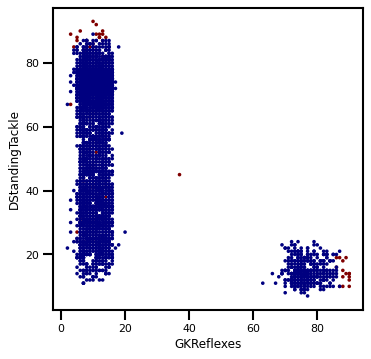

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
plt.scatter(df_cured[skill_1], y=df_cured[skill_2], s=3, c=bool_crack, cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Aquí se ven dos grupos bien diferenciados.

In [ ]:
skill_1 = interesting_cols[2]

In [ ]:
skill_1 = interesting_cols[3]

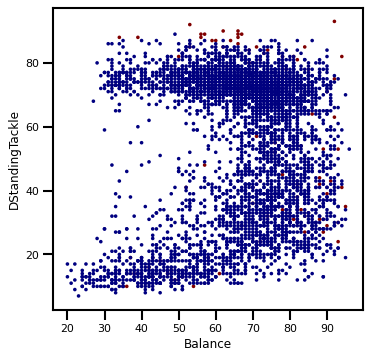

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
plt.scatter(df_cured[skill_1], y=df_cured[skill_2], s=3, c=bool_crack, cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Con estas dos columnas no se distinguen grupos claros.

In [ ]:
skill_1 = interesting_cols[4]

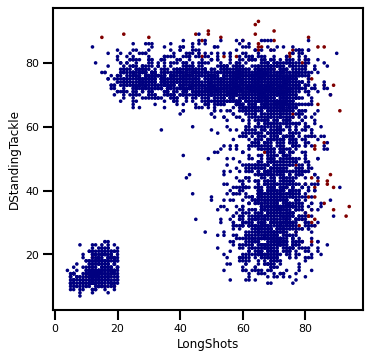

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
plt.scatter(df_cured[skill_1], y=df_cured[skill_2], s=3, c=bool_crack, cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Aquí se ven dos grupos bien definidos. Intuimos que el más grande puede estar segmentado pero no tenemos certeza.

In [ ]:
skill_1 = 'LongPassing'
skill_2 = 'ShotPower'

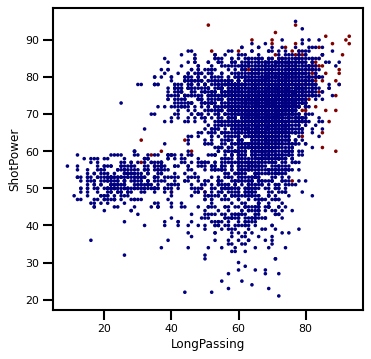

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
plt.scatter(df_cured[skill_1], y=df_cured[skill_2], s=3, c=bool_crack, cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

En estas dos columnas no hay una clara separación, pero se puede ver una región bastante densa en la parte superior.

In [ ]:
for col in not_skills:
  print(col, len(df_cured[col].unique()))

short_name 4494
potential 24
value_eur 223
wage_eur 134
age 26
height_cm 43
weight_kg 49
club_name 488
league_name 50
club_joined 995
nationality_name 114
preferred_foot 2
international_reputation 5
Position 5


Para simplificar el análisis grafico, dividmos en grupos de 5 a las 10 columnas y analizamos cada grupo en un gráfico separado.

In [ ]:
short_list = [    
    'GKReflexes',
    'DStandingTackle',
    'Acceleration',
    'Balance',
    'LongShots' 
]
    # 'Penalties', 
    # 'ShotPower', 
    # 'ACrossing', 
    # 'LongPassing', 
    # 'FKAccuracy'


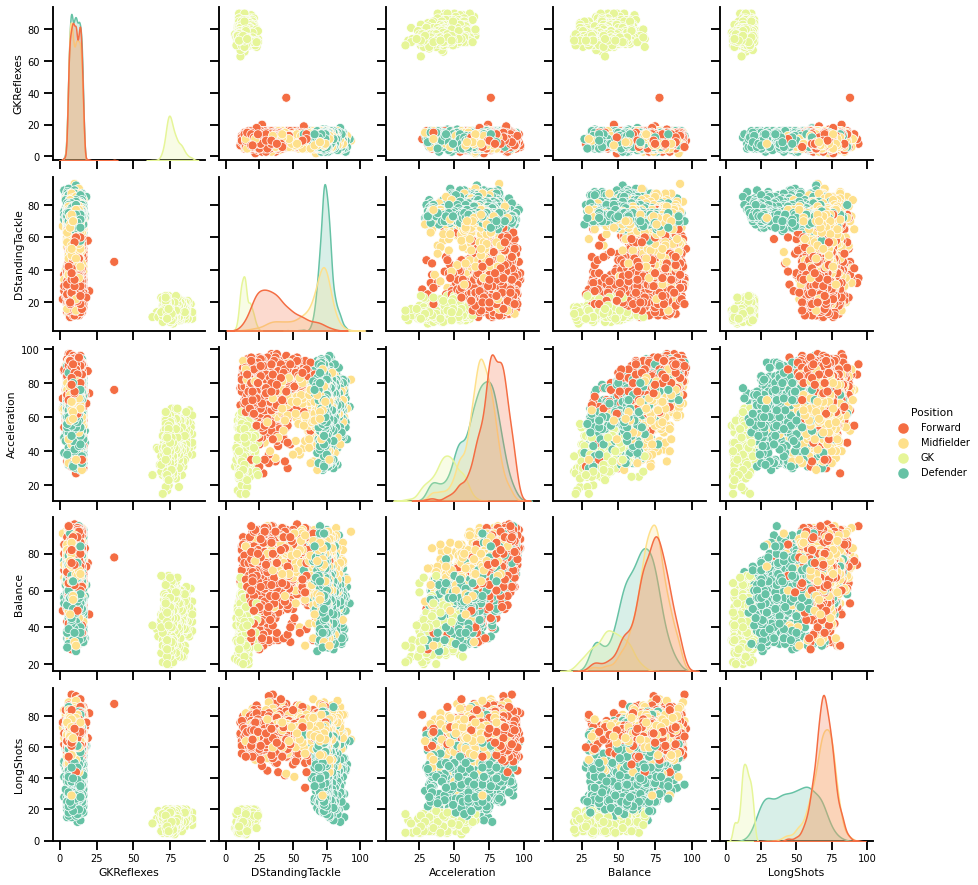

In [ ]:
sns.pairplot(data=df_cured[short_list+['Position']], hue='Position', palette='Spectral')

Pares de columnas que parecen separar por posición bastante:



* Acceleration - LongShots
* Acceleration - DStandingTackle
* DStandingTackle - LongShots

In [ ]:
other_list = [    
    'Penalties', 
    'ShotPower', 
    'ACrossing', 
    'LongPassing', 
    'FKAccuracy'
]    

    # 'GKReflexes',
    # 'DStandingTackle',
    # 'Acceleration',
    # 'Balance',
    # 'LongShots' ]


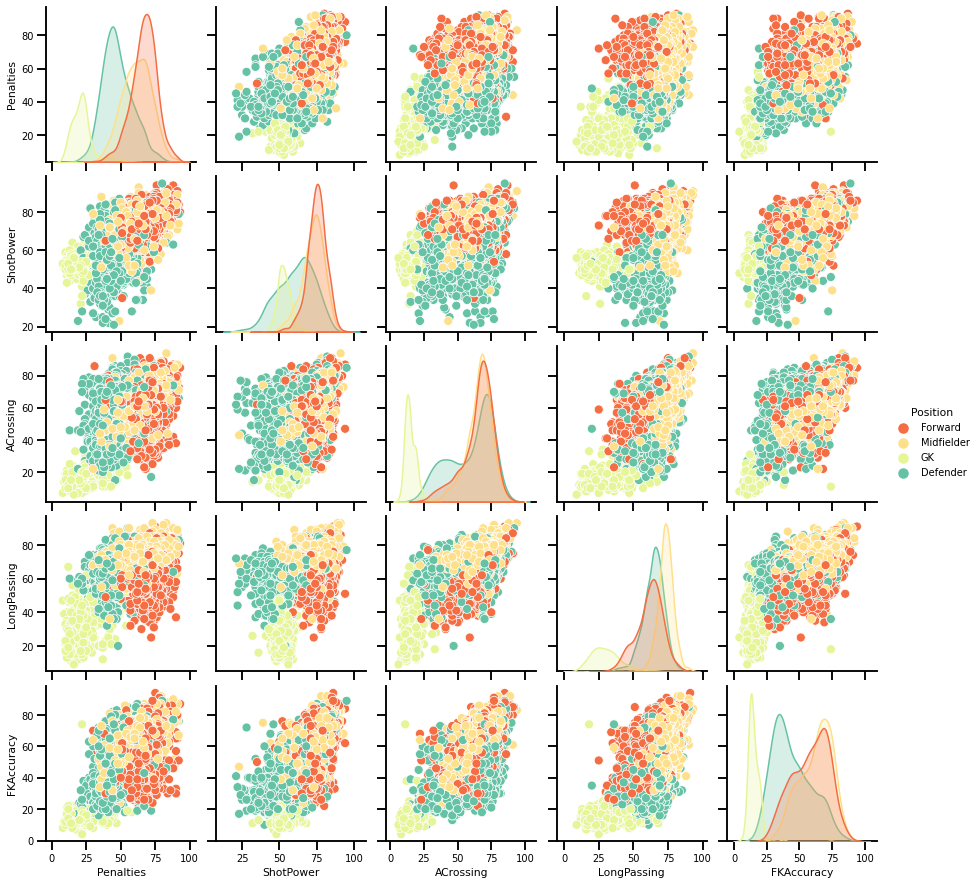

In [ ]:
sns.pairplot(data=df_cured[other_list+['Position']], hue='Position', palette='Spectral')

Pares de columnas que parecen separar por posición bastante:

* Penalties - LongPassing
* ShotPower - LongPassing
* FKAccuracy - LongPassing

Armamos otro grupo de mezclando algunas skills de los dos grupos anteriores.

In [ ]:
g_list = [    
    'Penalties', 
    'ShotPower', 
    'GKReflexes',
    'DStandingTackle',
    'Acceleration',

]    

# #    'ACrossing', 
#     'LongPassing', 
#     'FKAccuracy'

    # 'GKReflexes',
    # 'DStandingTackle',
    # 'Acceleration',
    # 'Balance',
    # 'LongShots' ]


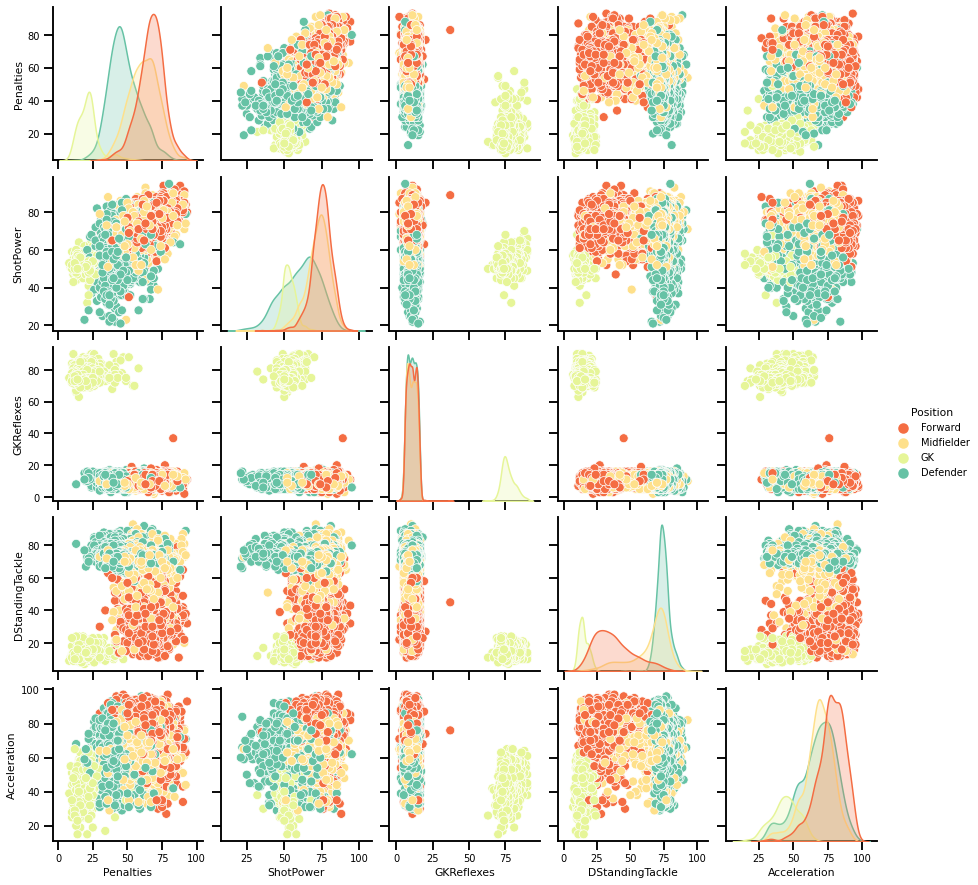

In [ ]:
sns.pairplot(data=df_cured[g_list+['Position']], hue='Position', palette='Spectral')

Pares de columnas que parecen separar por posición bastante:

* Penalties - DStandingTackle
* Penalties - Acceleration
* ShotPower - DStandingTackle

## 3. y 4. Clustering y Validación

### K-Means

#### Analisis de Codo

El número de clusters para K-means deducido por el Método del Codo viene a ser el K donde la inercia deja de caer abruptamente.

CPU times: user 5.33 s, sys: 2.27 s, total: 7.6 s
Wall time: 4 s


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

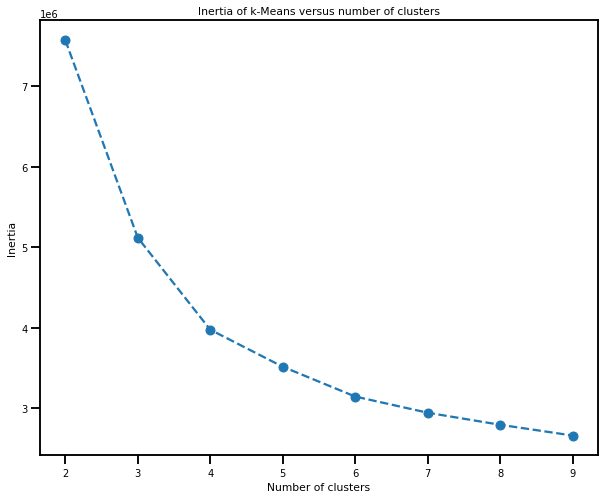

In [ ]:
# Analisis para determinar el hiperparámetro n_clusters, variando de 2 a 10 clusters
%%time
scores = [KMeans(n_clusters=i).fit(df_cured[interesting_cols]).inertia_ for i in range(2,10)]

plt.figure(figsize=(10,8))
plt.plot(np.arange(2, 10), scores, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

 El K indicado parece ser 4.

####Análisis de Silueta

**Coeficiente de silueta**

El coeficiente de silueta es una métrica utilizada para calcular la bondad de una técnica de agrupación. 

El mejor valor es 1 y el peor valor es -1. 

Los valores cercanos a 0 indican clústeres superpuestos. 

Los valores negativos generalmente indican que una muestra se ha asignado al conglomerado equivocado, ya que un conglomerado diferente es más similar.

In [ ]:
%%time
# Create empty list
S = []

# Range of clusters to try (2 to 10)
Ks = range(2,10)

# Select data for clustering model
X = df_cured[interesting_cols]

for k in Ks:
    # Set the model and its parameters
    model = KMeans(n_clusters=k)
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(silhouette_score(X, labels, metric='euclidean'))

CPU times: user 8.56 s, sys: 3.52 s, total: 12.1 s
Wall time: 6.95 s


In [ ]:
dict_results = dict(zip(Ks,S))
dict_results

{2: 0.6005292122544564,
 3: 0.3505363427020032,
 4: 0.31803463492404904,
 5: 0.27799471124540626,
 6: 0.2745405454192285,
 7: 0.2629886306791146,
 8: 0.24225064282229472,
 9: 0.22721685675761652}

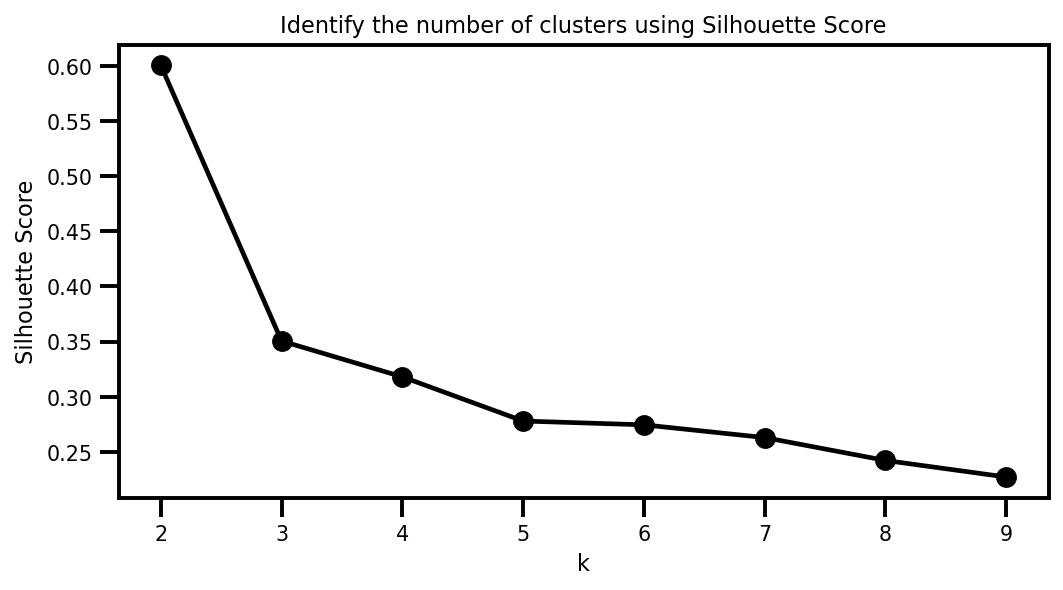

In [ ]:
# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(8,4), dpi=150)
plt.plot(Ks, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

A medida que el K crece, decrece el coeficiente de silueta. Con 2 clusters obtenemos un score buenos. Probablemente separa en dos grupos arqueros y no arqueros. Para 3 y 4 tampoco es muy bajo.

#### Aplicación de K-Means

##### K = 2

In [ ]:
# Número de clusters buscado
n_clust = 2

km2 = KMeans(n_clusters=n_clust, random_state=42)
km2.fit(df_cured[interesting_cols]) # utiliza todas las habilidades: 10 dimensiones

# Etiquetas asignadas por el algoritmo
clusters2 = km2.labels_
# Centroides
centroides2 = km2.cluster_centers_

In [ ]:
df_clusters = df_cured.copy()
df_clusters['kmeans2'] = km2.labels_
df_clusters['kmeans2'].value_counts()

1    4149
0     444
Name: kmeans2, dtype: int64

In [ ]:
df_clusters[df_clusters['kmeans2'] == 0].Position.unique()

array(['GK', nan], dtype=object)

In [ ]:
kmean_clusters2 = go.Scatter(x=df_cured['LongPassing'], y=df_cured['Penalties'],
                          mode='markers',
                          text=df_cured.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                          )

data2 = [kmean_clusters2]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig2 = go.Figure(data=data2, layout=layout)


In [ ]:
fig2.show(renderer="colab")

##### K = 3

In [ ]:
# Número de clusters buscado
n_clust = 3

km3 = KMeans(n_clusters=n_clust, random_state=42)
km3.fit(df_cured[interesting_cols]) # utiliza todas las habilidades: 10 dimensiones

# Etiquetas asignadas por el algoritmo
clusters3 = km3.labels_
# Centroides
centroides3 = km3.cluster_centers_

In [ ]:
df_clusters = df_clusters.copy()
df_clusters['kmeans3'] = km3.labels_
df_clusters['kmeans3'].value_counts()

0    2790
2    1359
1     444
Name: kmeans3, dtype: int64

In [ ]:
df_clusters[df_clusters['kmeans3'] == 1].Position.unique()

array(['GK', nan], dtype=object)

In [ ]:
kmean_clusters3 = go.Scatter(x=df_cured['LongPassing'], y=df_cured['Penalties'],
                          mode='markers',
                          text=df_cured.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters3.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                          )

data3 = [kmean_clusters3]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig3 = go.Figure(data=data3, layout=layout)


In [ ]:
fig3.show(renderer="colab")

In [ ]:
fig3d = px.scatter_3d(df_clusters, x='Position', y='age', z='international_reputation',
              color='kmeans3')

In [ ]:
#En Colab:
fig3d.show(renderer="colab")

Visualizando con columnas no numéricas, se puede observar:

El `cluster 0` tiene en su mayoría a delanteros, seguido de mediocampistas, y poca proporción de defensores con dominio de reputación internacional sobre todo entre 1 y 3.

El `cluster 1` se compone enteramente de arqueros, con algunos valores atípicos de reputación internacional de 4 y 5

El `cluster 2` abarca en su mayoría a los defensores y algunos mediocampistas, con reputación internacional entre 1 y 3, salvo por algunos de 4.

Los jugadores que comprenden la reputación internacional de 4 y 5 no parecen ser menores a 25 años de edad.


##### K = 4

In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=42)
km.fit(df_cured[interesting_cols]) # utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters = km.labels_
# Centroides
centroides = km.cluster_centers_

In [ ]:
df_clusters = df_clusters.copy()
df_clusters['kmeans4'] = km.labels_ # clusters
df_clusters['kmeans4'].value_counts()

0    1759
3    1353
2    1037
1     444
Name: kmeans4, dtype: int64

In [ ]:
df_clusters[df_clusters['kmeans4'] == 1].Position.unique()

array(['GK', nan], dtype=object)

> Efectivamente, el cluster minoritario se trata de arqueros y nans.

In [ ]:
fig = px.scatter_3d(df_clusters, x='Position', y='age', z='international_reputation',
              color='kmeans4')

In [ ]:
#En Colab:
fig.show(renderer="colab")

Visualizando con columnas no numéricas, se puede ver:

El `cluster 1` se corresponde con la posición de arqueros y nan sobretodo para reputación internacional 1.

El `cluster 3` se aprecia en los delanteros, para todas las reputaciones y edades, y algunos mediocampistas.

El `cluster 2` se corresponde en su mayoría por defensores y algunos mediocampistas, con reputación hasta 4.

El `cluster 0` se acerca más a los mediocampistas, y algunos defensores, también con reputación hasta 4.

Se observan algunos valores atípicos de reputación internacional 5 para algunos delanteros y un par de arqueros.

In [ ]:
kmean_clusters4 = go.Scatter(x=df_cured['LongPassing'], y=df_cured['Penalties'],
                          mode='markers',
                          text=df_cured.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                          )

data4 =[kmean_clusters4]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig4 = go.Figure(data=data4, layout=layout)


In [ ]:
fig4.show(renderer="colab")

> Los tres valores de K (2, 3, 4) se adaptan bastante bien en este clustering. Aunque el valor  3 parece ajustarse mejor.

### K-Means con subpoblación sin arqueros

Debido a que arqueros forma un grupo bastante distinguido del resto, veremos el comportamiento de K-Means con la subpoblación sin los mismos.

#### Preparación de datos

In [ ]:
df_train = df_cured.copy()
df_train.head(5)

ACrossing  AFinishing  AHeadingAccuracy  AShortPassing  AVolleys  \
0         85          95                70             91        88   
1         71          95                90             85        89   
2         87          95                90             80        86   
3         85          83                63             86        86   
4         94          82                55             94        82   

   Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0         96     93          94           91           96            91   
1         85     79          85           70           88            77   
2         88     81          84           77           88            85   
3         95     88          87           81           95            93   
4         88     85          83           93           91            76   

   SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  \
0           80       91         94       95         86       68       72   
1           79       77         93       82         90       85       76   
2           88       86         94       74         94       95       77   
3           89       96         89       84         80       64       81   
4           76       79         91       78         91       63       89   

   Strength  LongShots  Aggression  Interceptions  Positioning  Vision  \
0        69         94          44             40           93      95   
1        86         87          81             49           95      81   
2        77         93          63             29           95      76   
3        53         81          63             37           86      90   
4        74         91          76             66           88      94   

   Penalties  Composure  DMarking  DStandingTackle  DSlidingTackle  GKDiving  \
0         75         96        20               35              24         6   
1         90         88        35               42              19        15   
2         88         95        24               32              24         7   
3         93         93        35               32              29         9   
4         83         89        68               65              53        15   

   GKHandling  GKKicking  GKPositioning  GKReflexes  work_rate  \
0          11         15             14           8          7   
1           6         12              8          10          2   
2          11         15             14          11          1   
3           9         15             15          11          2   
4          13          5             10          13          0   

          short_name  potential    value_eur  wage_eur  age  height_cm  \
0           L. Messi         93   78000000.0  320000.0   34        170   
1     R. Lewandowski         92  119500000.0  270000.0   32        185   
2  Cristiano Ronaldo         91   45000000.0  270000.0   36        187   
3          Neymar Jr         91  129000000.0  270000.0   29        175   
4       K. De Bruyne         91  125500000.0  350000.0   30        181   

   weight_kg            club_name             league_name club_joined  \
0         72  Paris Saint-Germain          French Ligue 1  2021-08-10   
1         81    FC Bayern München    German 1. Bundesliga  2014-07-01   
2         83    Manchester United  English Premier League  2021-08-27   
3         68  Paris Saint-Germain          French Ligue 1  2017-08-03   
4         70      Manchester City  English Premier League  2015-08-30   

  nationality_name preferred_foot  international_reputation    Position  \
0        Argentina           Left                         5     Forward   
1           Poland          Right                         5     Forward   
2         Portugal          Right                         5     Forward   
3           Brazil          Right                         5     Forward   
4          Belgium          Right                         4  Midfielder   

   Overall

In [ ]:
df_train.drop(df_train.loc[df_train['Position']=='GK'].index, inplace=True)
df_train.head(5)

ACrossing  AFinishing  AHeadingAccuracy  AShortPassing  AVolleys  \
0         85          95                70             91        88   
1         71          95                90             85        89   
2         87          95                90             80        86   
3         85          83                63             86        86   
4         94          82                55             94        82   

   Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0         96     93          94           91           96            91   
1         85     79          85           70           88            77   
2         88     81          84           77           88            85   
3         95     88          87           81           95            93   
4         88     85          83           93           91            76   

   SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  \
0           80       91         94       95         86       68       72   
1           79       77         93       82         90       85       76   
2           88       86         94       74         94       95       77   
3           89       96         89       84         80       64       81   
4           76       79         91       78         91       63       89   

   Strength  LongShots  Aggression  Interceptions  Positioning  Vision  \
0        69         94          44             40           93      95   
1        86         87          81             49           95      81   
2        77         93          63             29           95      76   
3        53         81          63             37           86      90   
4        74         91          76             66           88      94   

   Penalties  Composure  DMarking  DStandingTackle  DSlidingTackle  GKDiving  \
0         75         96        20               35              24         6   
1         90         88        35               42              19        15   
2         88         95        24               32              24         7   
3         93         93        35               32              29         9   
4         83         89        68               65              53        15   

   GKHandling  GKKicking  GKPositioning  GKReflexes  work_rate  \
0          11         15             14           8          7   
1           6         12              8          10          2   
2          11         15             14          11          1   
3           9         15             15          11          2   
4          13          5             10          13          0   

          short_name  potential    value_eur  wage_eur  age  height_cm  \
0           L. Messi         93   78000000.0  320000.0   34        170   
1     R. Lewandowski         92  119500000.0  270000.0   32        185   
2  Cristiano Ronaldo         91   45000000.0  270000.0   36        187   
3          Neymar Jr         91  129000000.0  270000.0   29        175   
4       K. De Bruyne         91  125500000.0  350000.0   30        181   

   weight_kg            club_name             league_name club_joined  \
0         72  Paris Saint-Germain          French Ligue 1  2021-08-10   
1         81    FC Bayern München    German 1. Bundesliga  2014-07-01   
2         83    Manchester United  English Premier League  2021-08-27   
3         68  Paris Saint-Germain          French Ligue 1  2017-08-03   
4         70      Manchester City  English Premier League  2015-08-30   

  nationality_name preferred_foot  international_reputation    Position  \
0        Argentina           Left                         5     Forward   
1           Poland          Right                         5     Forward   
2         Portugal          Right                         5     Forward   
3           Brazil          Right                         5     Forward   
4          Belgium          Right                         4  Midfielder   

   Overall

In [ ]:
df_train['Position'].value_counts()

Defender      1468
Forward       1378
Midfielder    1283
Name: Position, dtype: int64

In [ ]:
df_train.isna().sum()
#df_train = df_train.dropna(axis=0)

ACrossing                    0
AFinishing                   0
AHeadingAccuracy             0
AShortPassing                0
AVolleys                     0
Dribbling                    0
Curve                        0
FKAccuracy                   0
LongPassing                  0
BallControl                  0
Acceleration                 0
SprintSpeed                  0
Agility                      0
Reactions                    0
Balance                      0
ShotPower                    0
Jumping                      0
Stamina                      0
Strength                     0
LongShots                    0
Aggression                   0
Interceptions                0
Positioning                  0
Vision                       0
Penalties                    0
Composure                    0
DMarking                     0
DStandingTackle              0
DSlidingTackle               0
GKDiving                     0
GKHandling                   0
GKKicking                    0
GKPositi

#### Analisis de Codo

CPU times: user 6.06 s, sys: 2.72 s, total: 8.78 s
Wall time: 4.53 s


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

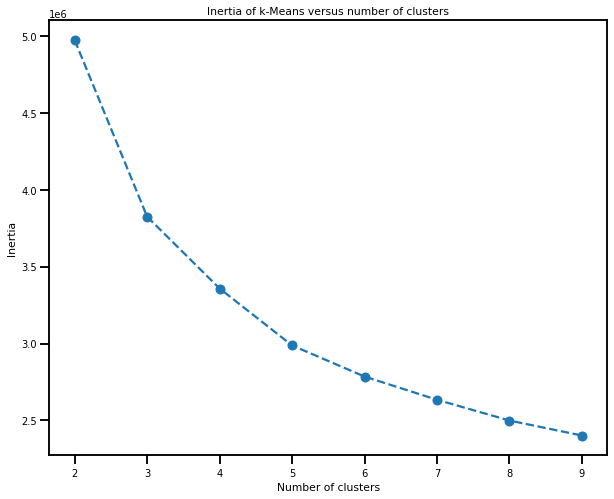

In [ ]:
# Analisis para determinar el hiperparámetro n_clusters, variando de 2 a 10 clusters
%%time
scores = [KMeans(n_clusters=i).fit(df_train[interesting_cols]).inertia_ for i in range(2,10)]

plt.figure(figsize=(10,8))
plt.plot(np.arange(2, 10), scores, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Parece ser K = 4

####Análisis de Silueta

In [ ]:
%%time
# Create empty list
S2 = []

# Range of clusters to try (2 to 10)
Ks2 = range(2,10)

# Select data for clustering model
X = df_train[interesting_cols]

for k in Ks2:
    # Set the model and its parameters
    model = KMeans(n_clusters=k)
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S2.append(silhouette_score(X, labels, metric='euclidean'))

CPU times: user 7.97 s, sys: 3.41 s, total: 11.4 s
Wall time: 6.42 s


In [ ]:
dict_results2 = dict(zip(Ks2,S2))
dict_results2

{2: 0.30873807634006994,
 3: 0.2711961650210183,
 4: 0.22887921033863828,
 5: 0.2239718622954671,
 6: 0.2129497802486175,
 7: 0.19048884997833823,
 8: 0.17258206127614945,
 9: 0.1634380117260116}

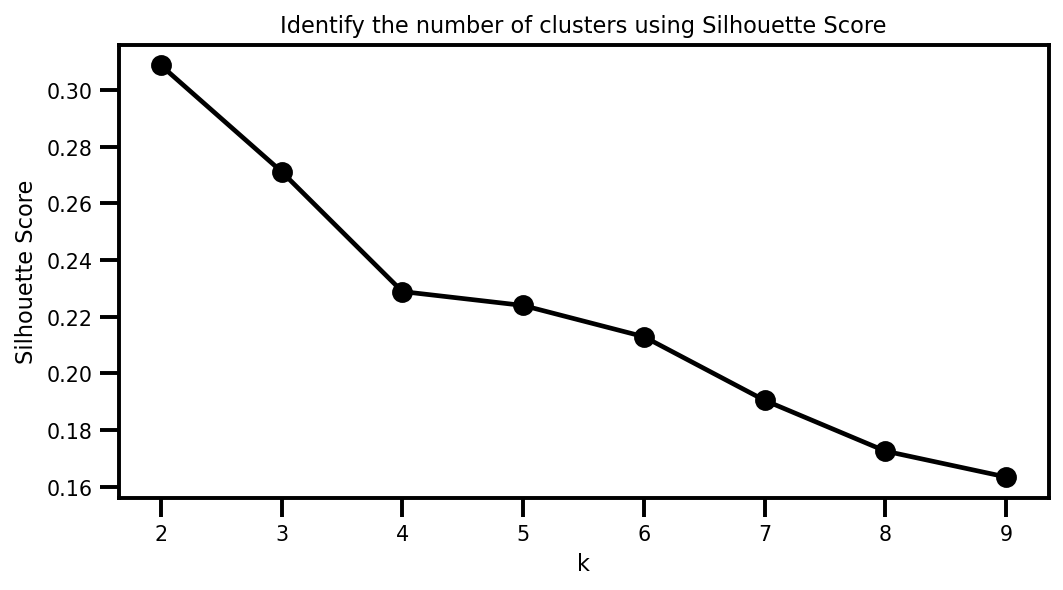

In [ ]:
# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(8,4), dpi=150)
plt.plot(Ks2, S2, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

Para K = 2 y K = 3 se distinque el mayor coeficiente de silueta.

#### Aplicación de K-Means

##### K = 2

In [ ]:
# Número de clusters buscado
n_clust = 2

km2_sin_GK = KMeans(n_clusters=n_clust, random_state=42)
km2_sin_GK.fit(df_train[interesting_cols]) # utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters2_sin_GK = km2_sin_GK.labels_
# Centroides
centroides2_sin_GK = km2_sin_GK.cluster_centers_

In [ ]:
df_clusters_sin_GK = df_train.copy()
df_clusters_sin_GK['kmeans2'] = km2_sin_GK.labels_
df_clusters_sin_GK['kmeans2'].value_counts()

0    2804
1    1350
Name: kmeans2, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans2'] == 0].Position.value_counts()

Forward       1350
Midfielder    1049
Defender       390
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans2'] == 1].Position.value_counts()

Defender      1078
Midfielder     234
Forward         28
Name: Position, dtype: int64

Recordemos las columnas que mejor parecían separar de acuerdo a posición:

    Penalties - DStandingTackle
    Penalties - Acceleration
    ShotPower - DStandingTackle

    Penalties - LongPassing
    ShotPower - LongPassing
    FKAccuracy - LongPassing

    Acceleration - LongShots
    Acceleration - DStandingTackle
    DStandingTackle - LongShots





In [ ]:
kmean_clusters2_sin_GK2 = go.Scatter(x=df_train['Acceleration'], y=df_train['LongShots'],
                          mode='markers',
                          text=df_train.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters2_sin_GK.astype(np.float),
                                colorscale='Portland',
                                showscale=False)
                          )

data22 = [kmean_clusters2_sin_GK2]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='Acceleration'),
                yaxis=dict(title='LongShots'),
                autosize=False, width=1000,height=650)

fig2_sin_GK2 = go.Figure(data=data22, layout=layout)


In [ ]:
fig2_sin_GK2.show(renderer="colab")

* En el cluster superior (0 - azul) se distintquen delanteros sobretodo y mediocampistas. 

* En cluster inferior (1 - rojo) comprende los defensores.

##### K = 3

In [ ]:
# Número de clusters buscado
n_clust = 3

km3_sin_GK = KMeans(n_clusters=n_clust, random_state=42)
km3_sin_GK.fit(df_train[interesting_cols]) # utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters3_sin_GK = km3_sin_GK.labels_
# Centroides
centroides3_sin_GK = km3_sin_GK.cluster_centers_

In [ ]:
df_clusters_sin_GK['kmeans3'] = km3_sin_GK.labels_ # clusters
df_clusters_sin_GK['kmeans3'].value_counts()

2    1770
0    1357
1    1027
Name: kmeans3, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans3'] == 0].Position.value_counts()

Forward       1142
Midfielder     210
Defender         1
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans3'] == 1].Position.value_counts()

Defender      888
Midfielder    116
Forward        15
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans3'] == 2].Position.value_counts()

Midfielder    957
Defender      579
Forward       221
Name: Position, dtype: int64

In [ ]:
kmean_clusters3_sin_GK = go.Scatter(x=df_train['LongPassing'], y=df_train['Penalties'],
                          mode='markers',
                          text=df_train.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters3_sin_GK.astype(np.float),
                                colorscale='Portland',
                                showscale=False)
                          )

data3 = [kmean_clusters3_sin_GK]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig3_sin_GK = go.Figure(data=data3, layout=layout)


In [ ]:
fig3_sin_GK.show(renderer="colab")

Los tres clusters tienen en su mayoría una posición distinta: delanteros, mediocampistas o defensores.

In [ ]:
fig3_sin_GK3 = px.scatter_3d(df_clusters_sin_GK, x='Position', y='age', z='international_reputation',
              color='kmeans3')

In [ ]:
#En Colab:
fig3_sin_GK3.show(renderer="colab")

Visualizando con columnas no numéricas, se puede ver:

El `cluster 0` abarca practicamente a los delanteros y algunos mediocampistas, para todas las reputaciones y edades salvo por algunos valores atípicos con reputación internacional 5 que no son menores a 30 años.

El `cluster 1` se corresponde con la posición de defensores sobretodo, para reputación internacional entre 1 y 3, y algunos valores atípicos en reputación internacional 4 con no menores a 35 años de edad.

El `cluster 2` se corresponde en su mayoría por  mediocampistas, con reputación internacional hasta 4 que es donde hay pocos jugadores con edad no menor a 25 años.

##### K = 4

In [ ]:
# Número de clusters buscado
n_clust = 4

km_sin_GK = KMeans(n_clusters=n_clust, random_state=42)
km_sin_GK.fit(df_train[interesting_cols]) # utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters_sin_GK = km_sin_GK.labels_
# Centroides
centroides_sin_GK = km_sin_GK.cluster_centers_

In [ ]:
df_clusters_sin_GK['kmeans4'] = km_sin_GK.labels_ 
df_clusters_sin_GK['kmeans4'].value_counts()

3    1272
2    1229
0    1010
1     643
Name: kmeans4, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans4'] == 0].Position.value_counts()

Defender      648
Midfielder    294
Forward        63
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans4'] == 1].Position.value_counts()

Defender      591
Midfielder     40
Forward         5
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans4'] == 2].Position.value_counts()

Midfielder    774
Defender      228
Forward       217
Name: Position, dtype: int64

In [ ]:
df_clusters_sin_GK[df_clusters_sin_GK['kmeans4'] == 3].Position.value_counts()

Forward       1093
Midfielder     175
Defender         1
Name: Position, dtype: int64

Se puede observar que el cluster más distinguible es el que tiene mayoría a delanteros.

In [ ]:
kmean_clusters4_sin_GK = go.Scatter(x=df_train['Acceleration'], y=df_train['LongShots'],
                          mode='markers',
                          text=df_train.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = clusters_sin_GK.astype(np.float),
                                colorscale='Portland',
                                showscale=False)
                          )

data4 =[kmean_clusters4_sin_GK]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title='Acceleration'),
                yaxis=dict(title='LongShots'),
                autosize=False, width=1000,height=650)

fig4_sin_GK = go.Figure(data=data4, layout=layout)


In [ ]:
fig4_sin_GK.show(renderer="colab")

Con estas dos columnas se nota una separación más clara de los clusters.

> Para la subpoblación sin arqueros, los K más apropiados parecen ser K = 2 y K = 3

### DB-Scan

DB-Scan utiliza dos parámetros: 
* epsilon: define el radio en el cual se buscaran los vecinos a un punto
* minPts: define la cantidad **mínima** de vecinos para que el mismo sea conciderado núcleo de un clusters

In [ ]:
df_train_db = df_cured.copy()

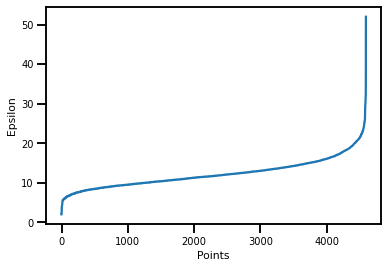

In [ ]:
# ¿Que valor de epsilon debería usar?
X = df_train_db[interesting_cols]

# calculo la distancia de cada punto a su vecino mas cercano
nn = NearestNeighbors(n_neighbors = 2)
nbrs = nn.fit(X)

# devuelve dos arreglos: Distancia a los vecino mas cercanoy el indice de cada punto
distances, indices = nbrs.kneighbors(X)

# Ordeno las distancias y las ploteo
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.ylabel("Epsilon")
plt.xlabel("Points")

plt.plot(distances)

Al parecer para valores de **épsilon** cercanos a 20 se produce un quiebre

In [ ]:
eps_values = np.arange(15,20) #valores de epsilon a verificar
min_samples = np.arange(5,20) #valores de min_samples a verificar

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
%%time
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    dbscan_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
    no_of_clusters.append(len(np.unique(dbscan_clustering.labels_)))
    sil_score.append(silhouette_score(X, dbscan_clustering.labels_))

CPU times: user 49.7 s, sys: 8.03 s, total: 57.7 s
Wall time: 49.3 s


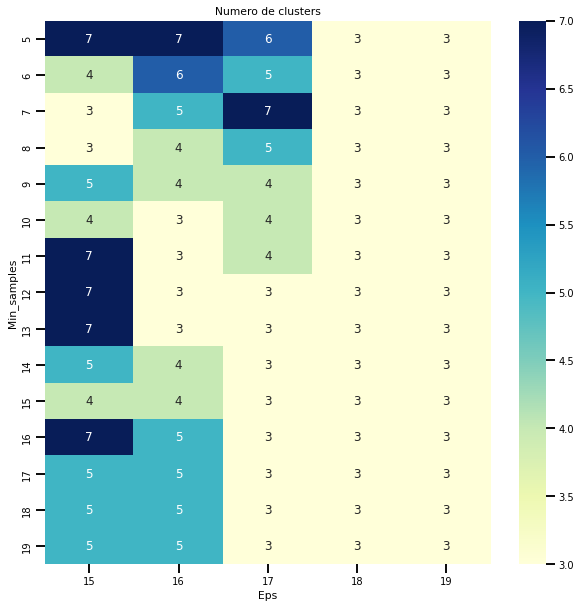

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 12}, cmap="YlGnBu", ax=ax)
ax.set_title('Numero de clusters')
plt.show()

La mayoria de las combinaciones genera 3 clusters (incluyendo el cluster de ruido que corresponde a la etiqueta de -1 en DB-Scan). Q

Quisieramos generar 4 clusters (5 con el cluster ruido) de acuerdo a la posición

In [ ]:
# Entrenamos el modelo
db = DBSCAN(eps=15, min_samples=19)

# predecimos los clusters
db_clusters = db.fit_predict(df_cured[interesting_cols])

df_train_db['cluster'] = db_clusters

# Cantidad de Clusters, ignorando los puntos de ruido.
n_clusters_ = len(set(db_clusters)) - (1 if -1 in db_clusters else 0)
n_noise_ = list(db_clusters).count(-1)

In [ ]:
print('Número de CLUSTERS: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, db_clusters))

Número de CLUSTERS: 4
Estimated number of noise points: 2179
Silhouette Coefficient: -0.064


In [ ]:
dbscan_clusters = go.Scatter(x=df_train_db['LongPassing'], y=df_train_db['Penalties'],
                          mode='markers',
                          text=df_train_db.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = db_clusters.astype(np.float),
                                colorscale='Portland',
                                showscale=False)
                          )

data_dbscan = [dbscan_clusters]

layout = go.Layout(title="Clustering DBSCAN ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data_dbscan, layout=layout)

In [ ]:
fig.show(renderer="colab")

Vemos que el coeficiente de Silhoette para DB-Scan es, si bien es más cercano al 0 que al -1, es negativo, por lo cual concluimos, observando además el gráfico que se ha asignado de forma incorrecta ejemplos a los clusters.

In [ ]:
# Entrenamos el modelo
db1 = DBSCAN(eps=17, min_samples=10)

# predecimos los clusters
db_clusters1 = db1.fit_predict(df_cured[interesting_cols])

df_train_db['clusters2'] = db_clusters1

# Cantidad de Clusters, ignorando los puntos de ruido.
n_clusters_1 = len(set(db_clusters1)) - (1 if -1 in db_clusters else 0)
n_noise_1= list(db_clusters1).count(-1)

In [ ]:
print('Número de CLUSTERS: %d' % n_clusters_1)
print('Estimated number of noise points: %d' % n_noise_1)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, db_clusters1))

Número de CLUSTERS: 3
Estimated number of noise points: 841
Silhouette Coefficient: 0.179


In [ ]:
dbscan_clusters1 = go.Scatter(x=df_train_db['LongPassing'], y=df_train_db['Penalties'],
                          mode='markers',
                          text=df_train_db.loc[:, 'Position'],
                          marker=dict(
                                size=5,
                                color = db_clusters1.astype(np.float),
                                colorscale='Portland',
                                showscale=False)
                          )

data_dbscan1 = [dbscan_clusters1]

layout1 = go.Layout(title="Clustering DB-Scan ",titlefont=dict(size=20),
                xaxis=dict(title='LongPassing'),
                yaxis=dict(title='Penalties'),
                autosize=False, width=1000,height=650)

fig_scan = go.Figure(data=data_dbscan1, layout=layout1)

In [ ]:
fig_scan.show(renderer="colab")

Vemos que el coeficiente de Silhoette para DB-Scan con estos hiperparámetros, es positivo aunque cercano al 0, por lo cual concluimos, observando además el gráfico que los clusters se solapan.

**Conclusión**: pareciera que el tipo de datos analizados no aplica correctamente el método DB-Scan ya que no logra realizar una separación clara de los clusters.

## 5. Normalización

No hizo falta, pues las variables consideradas estan en una magnitud con escala 0 - 100, lo cual no influye en los algoritmos de clustering. 

[Fuente]('https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02')

## 6. Embedding y clustering

### PCA

Aplicamos PCA para corroborar que en el análisis de componentes principales se observaran los clusters previamente encontrados.

In [ ]:
df_pca = df_cured.copy()[interesting_cols]


In [ ]:
df_cured

ACrossing  AFinishing  AHeadingAccuracy  AShortPassing  AVolleys  \
0            85          95                70             91        88   
1            71          95                90             85        89   
2            87          95                90             80        86   
3            85          83                63             86        86   
4            94          82                55             94        82   
...         ...         ...               ...            ...       ...   
4588         46          55                49             75        37   
4589         66          60                62             73        58   
4590         70          61                49             71        29   
4591         64          74                72             63        58   
4592         57          61                54             70        61   

      Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0            96     93          94           91           96            91   
1            85     79          85           70           88            77   
2            88     81          84           77           88            85   
3            95     88          87           81           95            93   
4            88     85          83           93           91            76   
...         ...    ...         ...          ...          ...           ...   
4588         65     56          65           73           70            63   
4589         73     73          63           70           70            69   
4590         71     74          35           69           72            80   
4591         66     56          49           57           65            79   
4592         71     60          49           74           78            59   

      SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  \
0              80       91         94       95         86       68       72   
1              79       77         93       82         90       85       76   
2              88       86         94       74         94       95       77   
3              89       96         89       84         80       64       81   
4              76       79         91       78         91       63       89   
...           ...      ...        ...      ...        ...      ...      ...   
4588           59       61         68       57         52       61       69   
4589           66       74         69       65         73       67       81   
4590           82       67         58       65         45       69       73   
4591           74       55         70       75         74       68       65   
4592           62       53         71       55         62       61       78   

      Strength  LongShots  Aggression  Interceptions  Positioning  Vision  \
0           69         94          44             40           93      95   
1           86         87          81             49           95      81   
2           77         93          63             29           95      76   
3           53         81          63             37           86      90   
4           74         91          76             66           88      94   
...        ...        ...         ...            ...          ...     ...   
4588        53         64          58             69           67      75   
4589        77         65          83             70           68      70   
4590        70         40          50             64           65      59   
4591        74         63          70             30           73      59   
4592        72         66          72             66           68      71   

      Penalties  Composure  DMarking  DStandingTackle  DSlidingTackle  \
0            75         96        20               35              24   
1            90         88        35               42              19   
2            88         95        24               32              24   
3            9

Analizamos pca para K=2,3 y 4

In [ ]:
df_pca 

GKReflexes  DStandingTackle  Acceleration  Balance  LongShots  \
0              8               35            91       95         94   
1             10               42            77       82         87   
2             11               32            85       74         93   
3             11               32            93       84         81   
4             13               65            76       78         91   
...          ...              ...           ...      ...        ...   
4588           9               70            63       57         64   
4589           8               74            69       65         65   
4590           9               70            80       65         40   
4591           8               38            79       75         63   
4592           9               70            59       55         66   

      Penalties  ShotPower  ACrossing  LongPassing  FKAccuracy  
0            75         86         85           91          94  
1            90         90         71           70          85  
2            88         94         87           77          84  
3            93         80         85           81          87  
4            83         91         94           93          83  
...         ...        ...        ...          ...         ...  
4588         60         52         46           73          65  
4589         66         73         66           70          63  
4590         40         45         70           69          35  
4591         63         74         64           57          49  
4592         48         62         57           74          49  

[4593 rows x 10 columns]

In [ ]:
pca = PCA(n_components=2)
pca_df_components = pca.fit_transform(df_pca) 
pca_df_components =pd.DataFrame(data = pca_df_components, columns = [ 'Componente_1', 'Componente_2'])
pca_nombres_df_components = pd.concat([pca_df_components, df_clusters.kmeans2], axis=1) 
pca_nombres_df_components

Componente_1  Componente_2  kmeans2
0       -71.020972    -40.285678        1
1       -53.287371    -36.831116        1
2       -61.096455    -45.685823        1
3       -60.614639    -43.051498        1
4       -70.639041    -12.400484        1
...            ...           ...      ...
4588     -8.401990     15.675653        1
4589    -25.409082     11.610040        1
4590      6.492722     29.448050        1
4591    -10.441203    -19.762743        1
4592     -4.532793     19.861569        1

[4593 rows x 3 columns]

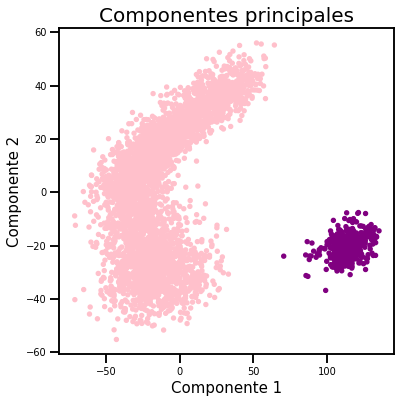

In [ ]:
fig =  plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel( 'Componente 1', fontsize = 15)
ax.set_ylabel( 'Componente 2', fontsize = 15)
ax.set_title( 'Componentes principales', fontsize = 20)  

color_theme = np.array(["purple", "pink"])
ax.scatter(x = pca_nombres_df_components.Componente_1, y = pca_nombres_df_components.Componente_2, c=color_theme[pca_nombres_df_components.kmeans2], s = 15  )


plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_df_components = pca.fit_transform(df_pca) 
pca_df_components =pd.DataFrame(data = pca_df_components, columns = [ 'Componente_1', 'Componente_2'])
pca_nombres_df_components = pd.concat([pca_df_components, df_clusters.kmeans3], axis=1) 
pca_nombres_df_components

Componente_1  Componente_2  kmeans3
0       -71.020972    -40.285678        0
1       -53.287371    -36.831116        0
2       -61.096455    -45.685823        0
3       -60.614639    -43.051498        0
4       -70.639041    -12.400484        0
...            ...           ...      ...
4588     -8.401990     15.675653        2
4589    -25.409082     11.610040        0
4590      6.492722     29.448050        2
4591    -10.441203    -19.762743        0
4592     -4.532793     19.861569        2

[4593 rows x 3 columns]

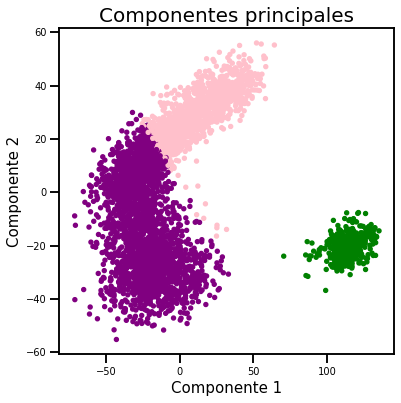

In [ ]:
fig =  plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel( 'Componente 1', fontsize = 15)
ax.set_ylabel( 'Componente 2', fontsize = 15)
ax.set_title( 'Componentes principales', fontsize = 20)  

color_theme = np.array(["purple", "green", "pink"])
ax.scatter(x = pca_nombres_df_components.Componente_1, 
           y = pca_nombres_df_components.Componente_2, 
           c=color_theme[pca_nombres_df_components.kmeans3], s = 15  )

plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_df_components = pca.fit_transform(df_pca) 
pca_df_components =pd.DataFrame(data = pca_df_components, columns = [ 'Componente_1', 'Componente_2'])
pca_nombres_df_components = pd.concat([pca_df_components, df_clusters.kmeans4], axis=1) 
pca_nombres_df_components

Componente_1  Componente_2  kmeans4
0       -71.020972    -40.285678        3
1       -53.287371    -36.831116        3
2       -61.096455    -45.685823        3
3       -60.614639    -43.051498        3
4       -70.639041    -12.400484        0
...            ...           ...      ...
4588     -8.401990     15.675653        0
4589    -25.409082     11.610040        0
4590      6.492722     29.448050        2
4591    -10.441203    -19.762743        3
4592     -4.532793     19.861569        0

[4593 rows x 3 columns]

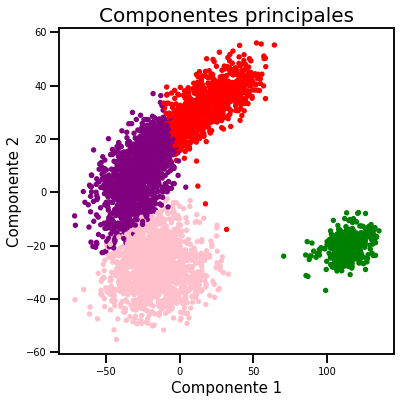

In [ ]:
fig =  plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel( 'Componente 1', fontsize = 15)
ax.set_ylabel( 'Componente 2', fontsize = 15)
ax.set_title( 'Componentes principales', fontsize = 20)  

color_theme = np.array(["purple", "green", "red", "pink"])
ax.scatter(x = pca_nombres_df_components.Componente_1, y = pca_nombres_df_components.Componente_2, c=color_theme[pca_nombres_df_components.kmeans4], s = 15  )


plt.show()

### T-SNE


In [ ]:
tnse_df_pca = pd.concat([df_pca, df_clusters['kmeans4'] ], axis=1) 
tnse_df_pca

GKReflexes  DStandingTackle  Acceleration  Balance  LongShots  \
0              8               35            91       95         94   
1             10               42            77       82         87   
2             11               32            85       74         93   
3             11               32            93       84         81   
4             13               65            76       78         91   
...          ...              ...           ...      ...        ...   
4588           9               70            63       57         64   
4589           8               74            69       65         65   
4590           9               70            80       65         40   
4591           8               38            79       75         63   
4592           9               70            59       55         66   

      Penalties  ShotPower  ACrossing  LongPassing  FKAccuracy  kmeans4  
0            75         86         85           91          94        3  
1            90         90         71           70          85        3  
2            88         94         87           77          84        3  
3            93         80         85           81          87        3  
4            83         91         94           93          83        0  
...         ...        ...        ...          ...         ...      ...  
4588         60         52         46           73          65        0  
4589         66         73         66           70          63        0  
4590         40         45         70           69          35        2  
4591         63         74         64           57          49        3  
4592         48         62         57           74          49        0  

[4593 rows x 11 columns]

T-distributed Stochastic Neighbor Embedding es un método no supervisado para visualización. Reduce observaciones n-dimensionales (n variables) a un espacio de 2 o 3 dimensiones para facilitar la observación.

Específicamente, modela cada objeto de alta dimensión a través de puntos bidimensionales o tridimensionales, de modo que los objetos similares son modelados por puntos cercanos y los objetos diferentes son modelados por puntos distantes con alta probabilidad.


Podemos usar el dataset df_pca pues solo era la copia del def_cured donde solo usamos las [interesting_cols].Luego pintamos de acuerdo a los grupos armados por Kmeans correspondientes a K=4

In [ ]:
#Definimos el modelo
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)

#Ajustamos el modelo
tsne_results = tsne.fit_transform(df_pca)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4593 samples in 0.005s...
[t-SNE] Computed neighbors for 4593 samples in 0.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4593
[t-SNE] Computed conditional probabilities for sample 2000 / 4593
[t-SNE] Computed conditional probabilities for sample 3000 / 4593
[t-SNE] Computed conditional probabilities for sample 4000 / 4593
[t-SNE] Computed conditional probabilities for sample 4593 / 4593
[t-SNE] Mean sigma: 8.429127
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.242188
[t-SNE] KL divergence after 300 iterations: 2.053190


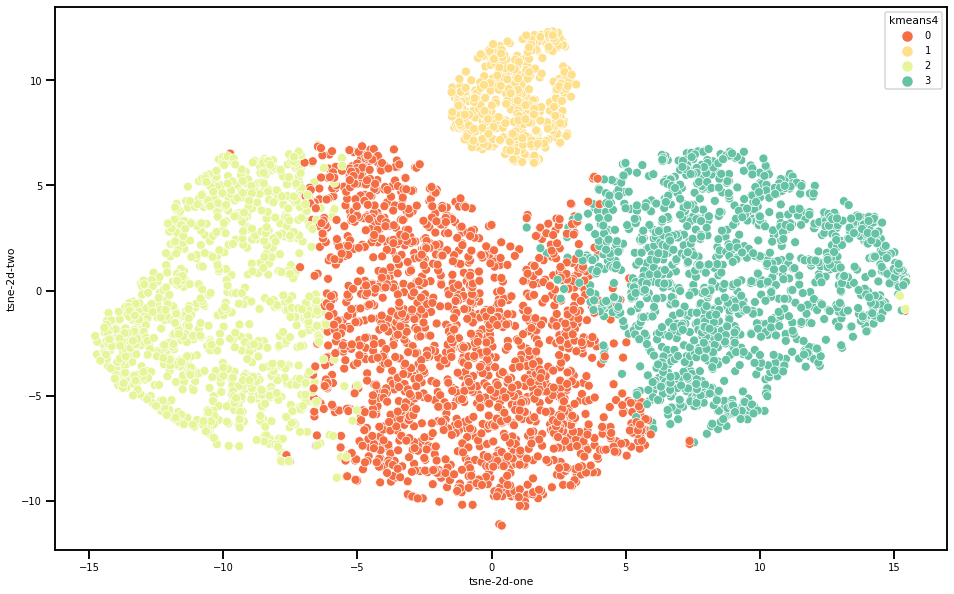

In [ ]:
# Dibuja una t-Sne bidimensional y pintamos de acuerdo a K=4 de kmeans
x_axis = df_pca['tsne-2d-one'] = tsne_results[:,0]
y_axis = df_pca['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#   hue= df_cured['Position'],  # 'Defender' : 1, 'Forward' : 3, 'GK' : 0, 'Midfielder' : 2}
    hue= tnse_df_pca['kmeans4'],  # 'Defender' : 1, 'Forward' : 3, 'GK' : 0, 'Midfielder' : 2}
    palette=sns.color_palette('Spectral', n_colors=4),
    data=df_pca,
    legend="full"
)

Observamos que ambos métodos de reducción de dimensiones logran separar de manera similar los datos, en donde se destacan claramente dos grupos. El grupo pequeño corresponde a solo una clase, y el mayor a tres clases.

Si pintamos por posiciones, obtenemos el siguiente grafico, en donde claramente se ve que el grupo menor aislado corresponde a los arqueros en tanto que el grupo mayor contiene de forma estratificada los delanteros, mediocampistas y defensores.

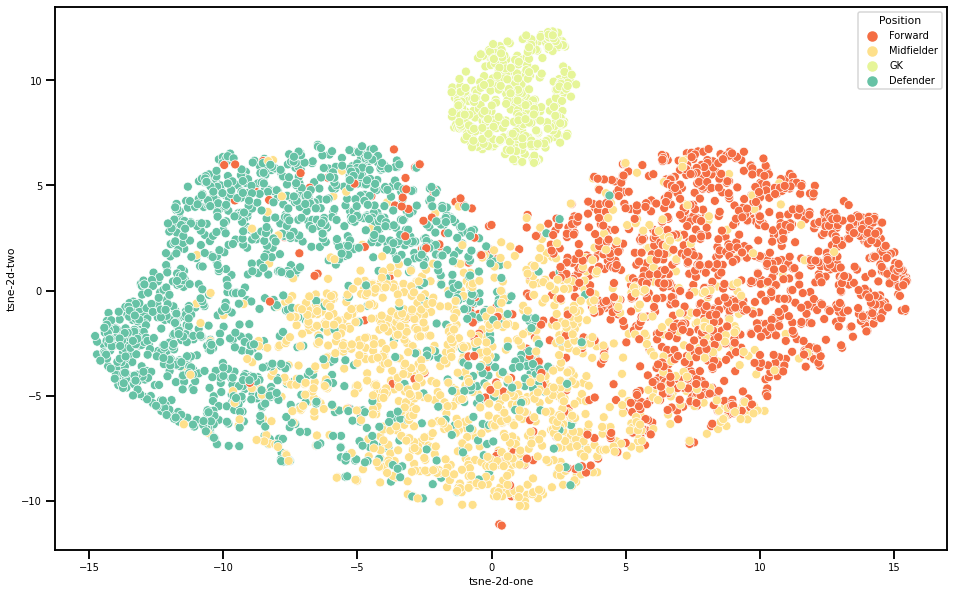

In [ ]:
# Dibuja una t-Sne bidimensional y pintamos de acuerdo a K=4 de kmeans
x_axis = df_pca['tsne-2d-one'] = tsne_results[:,0]
y_axis = df_pca['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue= df_cured['Position'],  

    palette=sns.color_palette('Spectral', n_colors=4),
    data=df_pca,
    legend="full"
)